In [3]:
#%% [markdown]
# # Generador de Reporte Ejecutivo - Revisión Sistemática
# ## Integración de Todos los Análisis
#
# Este notebook carga datos de una revisión sistemática, calcula métricas clave y genera varios formatos de reporte ejecutivo:
# 1. Dashboard interactivo (HTML con Plotly)
# 2. Informe detallado (PDF con FPDF)
# 3. Presentación resumida (HTML)
# 4. Resumen de una página (PNG con Matplotlib)
# 5. Archivo de metadatos (JSON)
# 6. Índice HTML para acceder a todos los reportes.

#%%
# ----------------------------------
# Importación de Librerías
# ----------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from fpdf import FPDF
import json
import logging
from typing import Dict, Any, List, Tuple, Optional

# Configuración de logging básico
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

#%%
# ----------------------------------
# Configuración y Constantes
# ----------------------------------
# --- Rutas ---
BASE_OUTPUT_DIR = Path("sistematica_output")
EXECUTIVE_DIR = BASE_OUTPUT_DIR / "executive_report"
INPUT_CSV_FILE = 'poblacionMetodologia.csv'

# --- Nombres de Archivos de Salida ---
DASHBOARD_HTML = 'executive_dashboard.html'
REPORT_PDF = 'informe_ejecutivo.pdf'
PRESENTATION_HTML = 'presentacion_ejecutiva.html'
ONE_PAGER_PNG = 'one_pager.png'
METADATA_JSON = 'metadata.json'
INDEX_HTML = 'index.html'

# --- Palabras Clave para Clasificación ---
# Intervenciones
INTERVENTION_KEYWORDS = {
    'AR/VR': ['ar', 'vr', 'augment', 'virtual'],
    'Juegos': ['game', 'gamif'],
    'Software': ['software'],
    'Adaptativo': ['adapt']
}
# Resultados Positivos
POSITIVE_RESULT_KEYWORDS = ['improved', 'significant', 'better', 'positive', 'effective', 'enhanced']
# Regiones (Ejemplos, ajustar según necesidad)
REGION_MAP = {
    'Asia': ['China', 'Japan', 'Indonesia', 'India', 'Korea', 'Taiwan', 'Malaysia'],
    'Europa': ['Spain', 'Italy', 'Poland', 'Hungary', 'Germany', 'UK', 'France', 'Portugal', 'Greece'],
    'América': ['Peru', 'Mexico', 'Colombia', 'USA', 'Canada', 'Brazil', 'Chile'],
    'Oceanía': ['Australia', 'New Zealand'],
    'África': ['South Africa', 'Nigeria', 'Egypt'] # Añadir países africanos si aplica
}
REGION_OTROS = 'Otros' # Nombre para países no clasificados

# --- Columnas del CSV (Asegurarse que coincidan con el archivo) ---
COL_YEAR = 'Year'
COL_COUNTRY = 'Country'
COL_INTERVENTION = 'Intervention'
COL_RESULTS = 'General Results'
COL_MIXED = 'Mixed Methods'
COL_QUANT = 'Quantitative Methods'
COL_QUAL = 'Qualitative Methods'

# Crear directorios de salida
EXECUTIVE_DIR.mkdir(parents=True, exist_ok=True)
logging.info(f"Directorio de salida asegurado: {EXECUTIVE_DIR}")

#%% [markdown]
# ## 1. Carga y Preparación de Datos
# Se carga el archivo CSV y se realiza una limpieza y preprocesamiento inicial. Se añaden columnas calculadas para facilitar los análisis posteriores (Tipo de Intervención, Región, Resultado Positivo).

#%%
# ----------------------------------
# Carga de Datos
# ----------------------------------
try:
    df = pd.read_csv(INPUT_CSV_FILE, sep=';', encoding='utf-8')
    logging.info(f"Archivo '{INPUT_CSV_FILE}' cargado exitosamente. {len(df)} filas encontradas.")
    # Limpieza básica: eliminar espacios extra en nombres de columnas si existen
    df.columns = df.columns.str.strip()
    # Convertir columna de año a numérico (manejando errores)
    df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors='coerce')
    df.dropna(subset=[COL_YEAR], inplace=True) # Eliminar filas sin año válido
    df[COL_YEAR] = df[COL_YEAR].astype(int)

    print("\nPrimeras 5 filas del DataFrame:")
    print(df.head())
    print("\nInformación del DataFrame:")
    df.info()

except FileNotFoundError:
    logging.error(f"Error: El archivo '{INPUT_CSV_FILE}' no fue encontrado.")
    raise # Detener ejecución si el archivo no existe
except Exception as e:
    logging.error(f"Error inesperado al cargar o procesar el CSV: {e}")
    raise

#%%
# --------------------------------------------------
# Funciones Helper para Clasificación (Uso Interno)
# --------------------------------------------------

def _classify_intervention(text: Optional[str]) -> str:
    """Clasifica el tipo de intervención basado en palabras clave."""
    if pd.isna(text):
        return "No especificado"
    text_lower = str(text).lower()
    for type_name, keywords in INTERVENTION_KEYWORDS.items():
        if any(term in text_lower for term in keywords):
            return type_name
    return "Otro" # O "No especificado" si se prefiere

def _classify_region(country: Optional[str]) -> str:
    """Clasifica la región geográfica basada en el país."""
    if pd.isna(country):
        return REGION_OTROS
    country_clean = str(country).strip()
    for region, countries_in_region in REGION_MAP.items():
        if any(c.lower() == country_clean.lower() for c in countries_in_region):
            return region
    return REGION_OTROS

def _is_positive_result(result: Optional[str]) -> bool:
    """Determina si el resultado general es positivo basado en palabras clave."""
    if pd.isna(result):
        return False
    result_lower = str(result).lower()
    return any(word in result_lower for word in POSITIVE_RESULT_KEYWORDS)

#%%
# ----------------------------------
# Preprocesamiento y Feature Engineering
# ----------------------------------
logging.info("Aplicando clasificaciones al DataFrame...")
df['Intervention_Type'] = df[COL_INTERVENTION].apply(_classify_intervention)
df['Region'] = df[COL_COUNTRY].apply(_classify_region)
df['Is_Positive_Result'] = df[COL_RESULTS].apply(_is_positive_result)

logging.info("Clasificaciones aplicadas.")
print("\nDistribución de Tipos de Intervención:")
print(df['Intervention_Type'].value_counts())
print("\nDistribución de Regiones:")
print(df['Region'].value_counts())
print("\nDistribución de Resultados Positivos:")
print(df['Is_Positive_Result'].value_counts())

print("\nDataFrame con nuevas columnas:")
print(df[[COL_YEAR, COL_COUNTRY, COL_INTERVENTION, COL_RESULTS, 'Intervention_Type', 'Region', 'Is_Positive_Result']].head())


#%% [markdown]
# ## 2. Cálculo de Métricas Clave
# Se calculan las métricas resumen que se usarán en los diferentes reportes.

#%%
# ----------------------------------
# Función para Calcular Métricas Clave
# ----------------------------------

def calculate_key_metrics(df: pd.DataFrame) -> Dict[str, Any]:
    """Calcula métricas clave para el reporte ejecutivo a partir del DataFrame preprocesado."""
    metrics = {}

    # Métricas básicas
    metrics['total_estudios'] = len(df)
    metrics['paises'] = df[COL_COUNTRY].nunique() # nunique maneja NaNs por defecto
    min_year, max_year = df[COL_YEAR].min(), df[COL_YEAR].max()
    metrics['años_cubiertos'] = f"{min_year}-{max_year}"
    metrics['año_minimo'] = min_year
    metrics['año_maximo'] = max_year

    # Metodologías (Contando no nulos en las columnas especificadas)
    # Asegurarse que las columnas existen antes de contar
    metrics['metodos_mixtos'] = df[COL_MIXED].notna().sum() if COL_MIXED in df.columns else 0
    metrics['metodos_cuantitativos'] = df[COL_QUANT].notna().sum() if COL_QUANT in df.columns else 0
    metrics['metodos_cualitativos'] = df[COL_QUAL].notna().sum() if COL_QUAL in df.columns else 0

    # Tipos de intervención (Usando la columna precalculada)
    intervention_counts = df['Intervention_Type'].value_counts()
    metrics['intervenciones_detalle'] = intervention_counts.to_dict()
    if not intervention_counts.empty:
        metrics['intervencion_dominante'] = intervention_counts.idxmax()
        if 'AR/VR' in intervention_counts:
           metrics['conteo_arvr'] = int(intervention_counts['AR/VR']) # Asegurar tipo int para JSON
           metrics['porcentaje_arvr'] = (metrics['conteo_arvr'] / metrics['total_estudios']) * 100
        else:
           metrics['conteo_arvr'] = 0
           metrics['porcentaje_arvr'] = 0.0
    else:
        metrics['intervencion_dominante'] = "N/A"
        metrics['conteo_arvr'] = 0
        metrics['porcentaje_arvr'] = 0.0


    # Resultados (Usando la columna precalculada)
    positive_results = df['Is_Positive_Result'].sum()
    metrics['resultados_positivos'] = int(positive_results) # Asegurar tipo int para JSON
    metrics['tasa_exito'] = (positive_results / metrics['total_estudios'] * 100) if metrics['total_estudios'] > 0 else 0.0

    # Regiones (Usando la columna precalculada)
    region_counts = df['Region'].value_counts()
    metrics['regiones_detalle'] = region_counts.to_dict()
    if not region_counts.empty:
        metrics['region_dominante'] = region_counts.idxmax()
    else:
        metrics['region_dominante'] = "N/A"

    return metrics

# --- Ejecutar Cálculo ---
logging.info("Calculando métricas clave...")
key_metrics = calculate_key_metrics(df)
logging.info("Métricas clave calculadas.")
print("\nMétricas Clave:")
# Imprimir métricas de forma legible
for k, v in key_metrics.items():
    if isinstance(v, float):
        print(f"- {k}: {v:.2f}")
    elif isinstance(v, dict):
        print(f"- {k}:")
        for sub_k, sub_v in v.items():
             print(f"  - {sub_k}: {sub_v}")
    else:
        print(f"- {k}: {v}")


#%% [markdown]
# ## 3. Creación de Visualización Ejecutiva Principal (Dashboard HTML)
# Se genera un dashboard interactivo con Plotly que incluye:
# * Tendencia temporal de publicaciones.
# * Distribución geográfica de los estudios.
# * Distribución de tipos de intervención.
# * Tasa de éxito por tipo de tecnología principal.

#%%
# ----------------------------------
# Función para Crear Dashboard Ejecutivo
# ----------------------------------

def create_executive_dashboard(df: pd.DataFrame, metrics: Dict[str, Any]) -> go.Figure:
    """Crea un dashboard ejecutivo interactivo con Plotly."""
    logging.info("Creando dashboard ejecutivo interactivo...")

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Tendencia Temporal (Estudios por Año)', 'Distribución Regional',
                        'Tipos de Intervención', 'Tasa de Éxito por Tecnología (%)'),
        specs=[[{"type": "scatter"}, {"type": "pie"}],
               [{"type": "bar"}, {"type": "bar"}]]
    )

    # 1. Tendencia temporal
    year_counts = df[COL_YEAR].value_counts().sort_index()
    fig.add_trace(
        go.Scatter(x=year_counts.index, y=year_counts.values,
                   mode='lines+markers', name='Estudios/Año',
                   line=dict(color='#1f77b4', width=3), marker=dict(size=8)),
        row=1, col=1
    )

    # 2. Distribución regional
    region_counts = df['Region'].value_counts()
    # Excluir 'Otros' o 'No especificado' si tienen muchas entradas y distorsionan la vista
    # region_counts = region_counts[~region_counts.index.isin([REGION_OTROS, 'No especificado'])]
    if not region_counts.empty:
        fig.add_trace(
            go.Pie(labels=region_counts.index, values=region_counts.values,
                   hole=.4, name='Regiones', marker_colors=go.Figure().layout.template.layout.colorway), # Usar colores del tema
            row=1, col=2
        )

    # 3. Tipos de intervención
    intervention_counts = df['Intervention_Type'].value_counts()
    # intervention_counts = intervention_counts[intervention_counts.index != 'No especificado'] # Opcional: excluir
    if not intervention_counts.empty:
        fig.add_trace(
            go.Bar(x=intervention_counts.index, y=intervention_counts.values,
                   name='Intervenciones',
                   marker_color=go.Figure().layout.template.layout.colorway), # Usar colores del tema
            row=2, col=1
        )

    # 4. Tasa de éxito por tecnología
    # Calcular tasa de éxito agrupando por tipo de intervención
    success_by_type = df.groupby('Intervention_Type')['Is_Positive_Result'].agg(['sum', 'count'])
    success_by_type['success_rate'] = (success_by_type['sum'] / success_by_type['count'] * 100).fillna(0)
    success_by_type = success_by_type.sort_values('success_rate', ascending=False)
    # success_by_type = success_by_type[success_by_type.index != 'No especificado'] # Opcional: excluir

    if not success_by_type.empty:
        fig.add_trace(
            go.Bar(x=success_by_type.index, y=success_by_type['success_rate'],
                   name='Tasa Éxito',
                   marker_color=go.Figure().layout.template.layout.colorway), # Usar colores del tema
            row=2, col=2
        )

    fig.update_layout(
        height=800,
        title_text="<b>Dashboard Ejecutivo - Revisión Sistemática</b>",
        title_x=0.5, # Centrar título
        showlegend=False,
        hovermode='x unified', # Mejorar tooltips
        template='plotly_white' # Tema limpio
    )

    # Actualizar títulos de ejes si es necesario
    fig.update_xaxes(title_text="Año", row=1, col=1)
    fig.update_yaxes(title_text="Nº Estudios", row=1, col=1)
    fig.update_xaxes(title_text="Tipo de Intervención", row=2, col=1)
    fig.update_yaxes(title_text="Nº Estudios", row=2, col=1)
    fig.update_xaxes(title_text="Tipo de Intervención", row=2, col=2)
    fig.update_yaxes(title_text="Tasa de Éxito (%)", row=2, col=2)


    # Guardar y mostrar
    output_path = EXECUTIVE_DIR / DASHBOARD_HTML
    fig.write_html(output_path)
    logging.info(f"Dashboard interactivo guardado en: {output_path}")
    fig.show() # Mostrar en el notebook
    return fig

# --- Ejecutar Creación Dashboard ---
dashboard_fig = create_executive_dashboard(df, key_metrics)


#%% [markdown]
# ## 4. Generación de Informe Ejecutivo en PDF
# Se crea un informe formal en PDF utilizando la librería FPDF, resumiendo los hallazgos clave y recomendaciones.

#%%
# ----------------------------------
# Clase para PDF Ejecutivo
# ----------------------------------

class ExecutiveReportPDF(FPDF):
    """Clase personalizada para generar el PDF con cabecera y pie de página."""
    def header(self):
        self.set_font('Arial', 'B', 15)
        self.cell(0, 10, 'Informe Ejecutivo - Revisión Sistemática', 0, 1, 'C')
        self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Página {self.page_no()}', 0, 0, 'C')

    def chapter_title(self, title: str):
        self.set_font('Arial', 'B', 14)
        self.set_fill_color(230, 230, 230) # Fondo gris claro para títulos
        self.cell(0, 10, title, 0, 1, 'L', fill=True)
        self.ln(5)

    def chapter_body(self, body: str):
        self.set_font('Arial', '', 12)
        # Usar 'latin-1' o 'cp1252' para manejar caracteres especiales si UTF-8 da problemas en FPDF
        try:
            self.multi_cell(0, 8, body.encode('latin-1', 'replace').decode('latin-1'))
        except UnicodeEncodeError:
             # Fallback simple si latin-1 falla
             self.multi_cell(0, 8, body.encode('ascii', 'replace').decode('ascii'))
        self.ln()

    def add_metric_box(self, title: str, value: Any, width: float = 90, color: Tuple[int, int, int] = (230, 230, 250)):
        """Añade un cuadro destacado para una métrica."""
        start_x = self.get_x()
        start_y = self.get_y()
        self.set_fill_color(*color)
        self.set_font('Arial', 'B', 10) # Título más pequeño
        # Dibujar rectángulo primero
        self.rect(start_x, start_y, width, 25, 'F')
        # Escribir texto encima
        self.set_xy(start_x, start_y + 2) # Ajustar Y para centrar texto
        self.cell(width, 8, title, 0, 1, 'C') # Mover a la siguiente línea
        self.set_x(start_x) # Volver a la X inicial para el valor
        self.set_font('Arial', 'B', 16) # Valor más grande
        self.cell(width, 10, str(value), 0, 1, 'C') # Mover a la siguiente línea
        self.set_y(start_y + 25) # Asegurar que la posición Y avance después del cuadro completo


#%%
# ----------------------------------
# Función para Generar PDF
# ----------------------------------

def generate_executive_pdf(metrics: Dict[str, Any]):
    """Genera un reporte ejecutivo en PDF."""
    logging.info("Generando informe ejecutivo en PDF...")
    pdf = ExecutiveReportPDF(orientation='P', unit='mm', format='A4')
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.set_left_margin(15)
    pdf.set_right_margin(15)

    # Resumen Ejecutivo
    pdf.chapter_title('Resumen Ejecutivo')
    summary = f"""Esta revisión sistemática analiza {metrics['total_estudios']} estudios sobre herramientas digitales interactivas en la enseñanza de matemáticas para educación primaria. La investigación cubre {metrics['paises']} países durante el período {metrics['años_cubiertos']}.

Los hallazgos principales indican que las tecnologías del tipo '{metrics.get('intervencion_dominante', 'N/A')}' son prevalentes. Notablemente, las intervenciones de AR/VR constituyen un {metrics.get('porcentaje_arvr', 0.0):.1f}% del total. La tasa de éxito general observada, basada en los resultados reportados, es del {metrics.get('tasa_exito', 0.0):.1f}%."""
    pdf.chapter_body(summary)

    # Métricas clave en cuadros
    pdf.chapter_title('Métricas Clave')
    initial_y_metrics = pdf.get_y()
    pdf.add_metric_box('Estudios Totales', metrics['total_estudios'], color=(200, 220, 255))
    pdf.set_xy(pdf.get_x() + 95, initial_y_metrics) # Mover a la derecha para el segundo cuadro
    pdf.add_metric_box('Países', metrics['paises'], color=(255, 200, 200))
    pdf.ln(5) # Espacio después de la primera fila de métricas

    initial_y_metrics_2 = pdf.get_y()
    pdf.add_metric_box('Métodos Mixtos', metrics['metodos_mixtos'], color=(200, 255, 200))
    pdf.set_xy(pdf.get_x() + 95, initial_y_metrics_2)
    pdf.add_metric_box('Tasa de Éxito', f"{metrics.get('tasa_exito', 0.0):.1f}%", color=(255, 255, 200))
    pdf.ln(10) # Espacio mayor después de las métricas


    # Hallazgos principales
    pdf.chapter_title('Hallazgos Principales')
    findings = f"""1.  **PREDOMINANCIA TECNOLÓGICA:** Las intervenciones de '{metrics.get('intervencion_dominante', 'N/A')}' son las más frecuentes. Las tecnologías AR/VR representan el {metrics.get('porcentaje_arvr', 0.0):.1f}% de los estudios analizados.

2.  **CONCENTRACIÓN GEOGRÁFICA:** La región de {metrics.get('region_dominante', 'N/A')} concentra la mayor cantidad de investigaciones publicadas en este campo dentro del corpus analizado.

3.  **EFECTIVIDAD GENERAL:** Un {metrics.get('tasa_exito', 0.0):.1f}% de los estudios ({metrics.get('resultados_positivos', 0)} de {metrics['total_estudios']}) reportan resultados positivos o mejoras significativas en el aprendizaje.

4.  **ENFOQUE METODOLÓGICO:** {metrics.get('metodos_mixtos', 0)} estudios emplean métodos mixtos, sugiriendo un interés en capturar la complejidad del fenómeno a través de datos cuantitativos y cualitativos."""
    pdf.chapter_body(findings)

    # Recomendaciones
    pdf.chapter_title('Recomendaciones Estratégicas')
    recommendations = """1.  **PARA EDUCADORES:** Considerar la integración de juegos educativos y, donde sea factible, tecnologías AR/VR, dado su potencial de impacto positivo. Es crucial acompañar la implementación con pedagogías activas y adaptadas.

2.  **PARA INVESTIGADORES:** Profundizar en los mecanismos de efectividad mediante diseños de métodos mixtos robustos. Realizar estudios longitudinales para evaluar la sostenibilidad de los efectos a largo plazo y la transferencia de aprendizajes. Explorar factores contextuales (socioeconómicos, culturales, nivel docente) que modulan el impacto.

3.  **PARA DESARROLLADORES:** Enfocarse en la usabilidad, accesibilidad y adaptabilidad de las herramientas. Integrar principios de diseño instruccional sólido y elementos de gamificación motivadores, basados en evidencia. Fomentar la interoperabilidad y la recolección ética de datos de aprendizaje.

4.  **PARA POLÍTICAS EDUCATIVAS:** Promover la inversión en infraestructura tecnológica y conectividad en las escuelas. Diseñar e implementar programas de desarrollo profesional docente continuos y específicos para el uso pedagógico efectivo de tecnologías emergentes. Fomentar la investigación y evaluación rigurosa de las implementaciones a escala."""
    pdf.chapter_body(recommendations)

    # Conclusiones
    pdf.chapter_title('Conclusiones')
    conclusions = f"""La evidencia acumulada en esta revisión sistemática ({metrics['años_cubiertos']}) sugiere que las herramientas digitales interactivas, particularmente {metrics.get('intervencion_dominante', 'las más comunes')}, tienen un potencial significativo para mejorar el aprendizaje de las matemáticas en educación primaria.

Las tecnologías AR/VR y los juegos educativos emergen como áreas prometedoras con altas tasas de éxito reportadas. Sin embargo, la efectividad real depende críticamente de factores como el diseño pedagógico, la integración curricular, el contexto de implementación y la preparación docente. Se requiere un enfoque holístico para maximizar los beneficios de estas herramientas."""
    pdf.chapter_body(conclusions)

    # Guardar PDF
    output_path = EXECUTIVE_DIR / REPORT_PDF
    try:
        pdf.output(output_path)
        logging.info(f"Informe PDF guardado en: {output_path}")
    except Exception as e:
        logging.error(f"Error al guardar el PDF: {e}")

    return pdf

# --- Ejecutar Generación PDF ---
pdf_report_obj = generate_executive_pdf(key_metrics)


#%% [markdown]
# ## 5. Creación de Presentación Ejecutiva (HTML Slides)
# Se genera una presentación simple en formato HTML, ideal para una visualización rápida en el navegador. Los datos se insertan dinámicamente.

#%%
# ----------------------------------
# Función para Crear Presentación HTML
# ----------------------------------
def create_executive_presentation(df: pd.DataFrame, metrics: Dict[str, Any]):
    """Crea una presentación ejecutiva simple en HTML."""
    logging.info("Creando presentación ejecutiva en HTML...")

    # Preparar datos para gráficos en JS (convertir a JSON)
    year_counts = df[COL_YEAR].value_counts().sort_index()
    trend_data_js = json.dumps({
        'x': year_counts.index.tolist(),
        'y': year_counts.values.tolist()
    })

    intervention_counts = df['Intervention_Type'].value_counts()
    intervention_data_js = json.dumps({
        'labels': intervention_counts.index.tolist(),
        'values': intervention_counts.values.tolist()
    })

    html_content = f"""
    <!DOCTYPE html>
    <html lang="es">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Presentación Ejecutiva - Revisión Sistemática</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 0; padding: 0; background: #f0f0f0; }}
            .slide {{
                width: 100%; min-height: 95vh; display: flex; flex-direction: column;
                justify-content: center; align-items: center; padding: 40px;
                box-sizing: border-box; background: white; border-bottom: 5px solid #e0e0e0;
                scroll-snap-align: start; /* Para posible snapping de scroll */
            }}
            .slide:last-child {{ border-bottom: none; }}
            .slide-title {{ font-size: 2.8em; color: #2c3e50; margin-bottom: 25px; text-align: center; }}
            .slide-subtitle {{ font-size: 1.4em; color: #3498db; margin-bottom: 30px; text-align: center;}}
            .slide-content {{ font-size: 1.4em; color: #34495e; max-width: 900px; text-align: center; line-height: 1.6; }}
            .metrics-grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 25px; width: 100%; max-width: 800px; margin: 30px 0; }}
            .metric-box {{ background: linear-gradient(135deg, #3498db, #2980b9); color: white; padding: 25px; border-radius: 12px; text-align: center; box-shadow: 0 4px 8px rgba(0,0,0,0.1); }}
            .metric-value {{ font-size: 2.5em; font-weight: bold; margin-bottom: 8px; }}
            .metric-label {{ font-size: 1.1em; }}
            .key-findings, .recommendations {{ text-align: left; margin: 25px 0; width: 100%; max-width: 800px; }}
            .finding, .recommendation {{ margin: 18px 0; padding: 18px; background: #ecf0f1; border-left: 6px solid #3498db; border-radius: 6px; font-size: 1.1em;}}
            .recommendation {{ background: #e8f8f5; border-left-color: #2ecc71; }}
            strong {{ color: #2c3e50; }}
            .chart-container {{ width: 100%; max-width: 700px; margin: 20px auto; }}
            /* Colores alternativos para cajas */
            .metric-box.green {{ background: linear-gradient(135deg, #2ecc71, #27ae60); }}
            .metric-box.red {{ background: linear-gradient(135deg, #e74c3c, #c0392b); }}
            .metric-box.purple {{ background: linear-gradient(135deg, #9b59b6, #8e44ad); }}
        </style>
    </head>
    <body>

    <div class="slide">
        <h1 class="slide-title">Herramientas Digitales en Matemáticas</h1>
        <p class="slide-subtitle">Revisión Sistemática de Educación Primaria ({metrics['años_cubiertos']})</p>
        <div class="slide-content">
            <p>Análisis de <strong>{metrics['total_estudios']}</strong> estudios de <strong>{metrics['paises']}</strong> países.</p>
        </div>
    </div>

    <div class="slide">
        <h2 class="slide-title">Métricas Clave</h2>
        <div class="metrics-grid">
            <div class="metric-box">
                <div class="metric-value">{metrics['total_estudios']}</div>
                <div class="metric-label">Estudios Analizados</div>
            </div>
            <div class="metric-box green">
                <div class="metric-value">{metrics.get('tasa_exito', 0.0):.1f}%</div>
                <div class="metric-label">Tasa de Éxito General</div>
            </div>
            <div class="metric-box red">
                <div class="metric-value">{metrics.get('porcentaje_arvr', 0.0):.1f}%</div>
                <div class="metric-label">Estudios AR/VR</div>
            </div>
            <div class="metric-box purple">
                <div class="metric-value">{metrics['metodos_mixtos']}</div>
                <div class="metric-label">Estudios Mét. Mixtos</div>
            </div>
        </div>
    </div>

    <div class="slide">
        <h2 class="slide-title">Hallazgos Principales</h2>
        <div class="key-findings">
            <div class="finding">
                <strong>Dominancia Tecnológica:</strong> '{metrics.get('intervencion_dominante', 'N/A')}' son las intervenciones más comunes ({metrics.get('porcentaje_arvr', 0.0):.1f}% son AR/VR).
            </div>
            <div class="finding">
                <strong>Foco Geográfico:</strong> {metrics.get('region_dominante', 'N/A')} lidera la producción científica en el área.
            </div>
            <div class="finding">
                <strong>Efectividad Reportada:</strong> {metrics.get('resultados_positivos', 0)} de {metrics['total_estudios']} estudios ({metrics.get('tasa_exito', 0.0):.1f}%) indican resultados positivos.
            </div>
            <div class="finding">
                <strong>Metodología Preferida:</strong> Creciente uso de métodos mixtos ({metrics['metodos_mixtos']} estudios) para análisis comprensivos.
            </div>
        </div>
    </div>

    <div class="slide">
        <h2 class="slide-title">Tendencias y Distribuciones</h2>
        <div class="chart-container">
            <div id="trendChart"></div>
        </div>
         <div class="chart-container">
            <div id="interventionChart"></div>
        </div>
        <script>
            // --- Gráfico de Tendencia ---
            var trendData = {json.loads(trend_data_js)};
            var traceTrend = {{
                x: trendData.x, y: trendData.y, type: 'scatter',
                mode: 'lines+markers', marker: {{size: 10, color: '#3498db'}}, line: {{width: 3}}
            }};
            var layoutTrend = {{
                title: 'Estudios por Año', xaxis: {{title: 'Año'}}, yaxis: {{title: 'Número de Estudios'}},
                margin: {{ l: 50, r: 30, t: 50, b: 50 }}, paper_bgcolor: 'rgba(0,0,0,0)', plot_bgcolor: 'rgba(0,0,0,0)'
            }};
            Plotly.newPlot('trendChart', [traceTrend], layoutTrend, {{responsive: true}});

            // --- Gráfico de Intervenciones ---
            var interventionData = {json.loads(intervention_data_js)};
            var traceIntervention = {{
                x: interventionData.labels, y: interventionData.values, type: 'bar',
                marker: {{ color: ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'] }} // Colores
            }};
             var layoutIntervention = {{
                title: 'Distribución de Tipos de Intervención', xaxis: {{title: 'Tipo de Intervención'}}, yaxis: {{title: 'Número de Estudios'}},
                margin: {{ l: 50, r: 30, t: 50, b: 100 }}, paper_bgcolor: 'rgba(0,0,0,0)', plot_bgcolor: 'rgba(0,0,0,0)'
            }};
            Plotly.newPlot('interventionChart', [traceIntervention], layoutIntervention, {{responsive: true}});
        </script>
    </div>

    <div class="slide">
        <h2 class="slide-title">Recomendaciones Estratégicas</h2>
        <div class="recommendations">
            <div class="recommendation">
                <strong>Para Educadores:</strong> Priorizar juegos y AR/VR con pedagogía sólida.
            </div>
            <div class="recommendation">
                <strong>Para Investigadores:</strong> Usar métodos mixtos y estudios longitudinales.
            </div>
            <div class="recommendation">
                <strong>Para Desarrolladores:</strong> Enfocar en usabilidad, adaptabilidad y diseño instruccional.
            </div>
            <div class="recommendation">
                <strong>Para Políticas Educativas:</strong> Invertir en infraestructura y formación docente continua.
            </div>
        </div>
    </div>

    <div class="slide">
        <h2 class="slide-title">Conclusiones Clave</h2>
        <div class="slide-content">
            <p>Las herramientas digitales interactivas muestran un <strong>impacto positivo general</strong> en el aprendizaje matemático primario.</p>
            <br>
            <p><strong>AR/VR y Juegos Educativos</strong> destacan como las intervenciones más prometedoras y efectivas reportadas.</p>
            <br>
            <p>El éxito requiere <strong>atención al contexto, diseño pedagógico y capacitación docente</strong> para una implementación efectiva.</p>
        </div>
    </div>

    </body>
    </html>
    """

    # Guardar presentación
    output_path = EXECUTIVE_DIR / PRESENTATION_HTML
    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(html_content)
        logging.info(f"Presentación HTML guardada en: {output_path}")
    except Exception as e:
        logging.error(f"Error al guardar la presentación HTML: {e}")

    return html_content

# --- Ejecutar Creación Presentación ---
presentation_html = create_executive_presentation(df, key_metrics)

#%% [markdown]
# ## 6. Creación de Informe de Una Página (One-Pager PNG)
# Se genera una imagen PNG que resume los puntos más importantes en un formato visualmente atractivo y conciso, utilizando Matplotlib.

#%%
# ----------------------------------
# Función para Crear One-Pager
# ----------------------------------

def create_one_pager(df: pd.DataFrame, metrics: Dict[str, Any]):
    """Crea un resumen ejecutivo de una página en formato PNG."""
    logging.info("Creando resumen One-Pager en PNG...")

    # Preparar datos para gráficos del one-pager
    intervention_counts = df['Intervention_Type'].value_counts().head(5) # Top 5 intervenciones
    year_counts = df[COL_YEAR].value_counts().sort_index()

    # Crear figura de una página (tamaño A4 aproximado en pulgadas para 300 dpi)
    fig = plt.figure(figsize=(8.27, 11.69), dpi=100) # A4 size in inches
    fig.patch.set_facecolor('white')

    # --- Estilos ---
    TITLE_COLOR = '#1a237e' # Azul oscuro
    SUBTITLE_COLOR = '#3f51b5' # Azul índigo
    TEXT_COLOR = '#212121' # Gris oscuro
    HIGHLIGHT_COLOR = '#ff6f00' # Naranja ámbar
    BOX_BG_COLOR = '#e8eaf6' # Azul muy claro
    BAR_COLORS = ['#3f51b5', '#ff6f00', '#4caf50', '#f44336', '#9c27b0'] # Paleta de colores

    # --- Título Principal ---
    plt.figtext(0.5, 0.96, 'REVISIÓN SISTEMÁTICA EJECUTIVA', ha='center', va='top',
                fontsize=20, fontweight='bold', color=TITLE_COLOR)
    plt.figtext(0.5, 0.93, 'Herramientas Digitales en Matemáticas (Educación Primaria)',
                ha='center', va='top', fontsize=14, color=SUBTITLE_COLOR)
    plt.figtext(0.5, 0.91, f"Periodo: {metrics['años_cubiertos']}", ha='center', va='top', fontsize=10, color=TEXT_COLOR)

    # Línea divisoria
    plt.axhline(y=0.89, xmin=0.05, xmax=0.95, color='#bdbdbd', linewidth=0.8)

    # --- Sección de Métricas Clave (Horizontal) ---
    metrics_y = 0.84
    metrics_data = [
        (metrics['total_estudios'], 'Estudios'),
        (metrics['paises'], 'Países'),
        (f"{metrics.get('tasa_exito', 0.0):.0f}%", 'Éxito Gral.'),
        (metrics.get('intervencion_dominante', 'N/A'), 'Tec. Principal')
    ]
    num_metrics = len(metrics_data)
    metric_box_width = 0.8 / num_metrics
    for i, (value, label) in enumerate(metrics_data):
        x_center = 0.1 + (i + 0.5) * metric_box_width
        # Cuadro sutil
        rect = plt.Rectangle((x_center - metric_box_width*0.45, metrics_y - 0.05), metric_box_width*0.9, 0.07,
                             facecolor=BOX_BG_COLOR, alpha=0.6, transform=fig.transFigure,
                             edgecolor='#bdbdbd', linewidth=0.5, clip_on=False)
        fig.patches.append(rect)
        # Valor
        plt.figtext(x_center, metrics_y, str(value), ha='center', va='center',
                    fontsize=18, fontweight='bold', color=TITLE_COLOR)
        # Etiqueta
        plt.figtext(x_center, metrics_y - 0.035, label, ha='center', va='center',
                    fontsize=9, color=TEXT_COLOR)

    # --- Sección de Hallazgos Principales ---
    findings_y_start = 0.72
    plt.figtext(0.08, findings_y_start, 'HALLAZGOS PRINCIPALES',
                fontsize=14, fontweight='bold', color=SUBTITLE_COLOR)

    findings_list = [
        f"Predominio de '{metrics.get('intervencion_dominante', 'N/A')}' ({metrics.get('porcentaje_arvr', 0.0):.0f}% AR/VR).",
        f"Alta concentración de estudios en {metrics.get('region_dominante', 'N/A')}.",
        f"{metrics.get('resultados_positivos', 0)} estudios ({metrics.get('tasa_exito', 0.0):.0f}%) reportan resultados positivos.",
        f"{metrics.get('metodos_mixtos', 0)} usan Métodos Mixtos, buscando análisis profundos."
    ]
    for i, finding in enumerate(findings_list):
        plt.figtext(0.1, findings_y_start - 0.04 - i * 0.035, f"• {finding}",
                    fontsize=10, color=TEXT_COLOR, wrap=True, va='top', ha='left',
                    bbox=dict(facecolor='white', alpha=0, pad=0)) # Wrap text

    # Línea divisoria
    plt.axhline(y=findings_y_start - 0.04 - len(findings_list) * 0.035 - 0.01, xmin=0.05, xmax=0.95, color='#e0e0e0', linewidth=0.6, linestyle='--')

    # --- Gráficos Incrustados ---
    chart_y = 0.35
    chart_height = 0.22

    # Gráfico 1: Tipos de Intervención (Barras Horizontales)
    ax1 = fig.add_axes([0.1, chart_y, 0.38, chart_height]) # x, y, width, height
    interv_labels = intervention_counts.index
    interv_values = intervention_counts.values
    y_pos = range(len(interv_labels))
    ax1.barh(y_pos, interv_values, color=BAR_COLORS[:len(interv_values)], align='center', height=0.6)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(interv_labels, fontsize=8)
    ax1.invert_yaxis() # Títulos arriba
    ax1.set_xlabel('Nº Estudios', fontsize=9)
    ax1.set_title('Top 5 Tipos de Intervención', fontsize=11, fontweight='bold', color=SUBTITLE_COLOR)
    ax1.tick_params(axis='x', labelsize=8)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Gráfico 2: Tendencia Temporal (Línea)
    ax2 = fig.add_axes([0.55, chart_y, 0.38, chart_height])
    years = year_counts.index
    studies = year_counts.values
    ax2.plot(years, studies, marker='o', linestyle='-', color=HIGHLIGHT_COLOR, linewidth=2, markersize=5)
    ax2.set_title('Tendencia Temporal', fontsize=11, fontweight='bold', color=SUBTITLE_COLOR)
    ax2.set_ylabel('Nº Estudios', fontsize=9)
    ax2.set_xlabel('Año', fontsize=9)
    ax2.tick_params(axis='both', labelsize=8)
    ax2.grid(axis='y', linestyle='--', alpha=0.6)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    # Asegurarse de que todos los años se muestren si no son demasiados
    if len(years) < 10:
        ax2.set_xticks(years)


    # --- Sección de Recomendaciones Clave ---
    rec_y_start = 0.25
    plt.figtext(0.08, rec_y_start, 'RECOMENDACIONES CLAVE',
                fontsize=14, fontweight='bold', color=SUBTITLE_COLOR)

    recommendations_list = [
        "Priorizar AR/VR y Juegos con pedagogía sólida.",
        "Adoptar Métodos Mixtos y estudios longitudinales.",
        "Fomentar desarrollo centrado en usabilidad y adaptabilidad.",
        "Invertir en formación docente continua y específica."
    ]
    for i, rec in enumerate(recommendations_list):
        plt.figtext(0.1, rec_y_start - 0.035 - i * 0.03, f"» {rec}",
                    fontsize=10, color=TEXT_COLOR, wrap=True, va='top', ha='left')

    # --- Pie de página ---
    plt.figtext(0.5, 0.02, f'Generado el {datetime.now().strftime("%d/%m/%Y %H:%M:%S")} | Basado en {metrics["total_estudios"]} estudios.',
                ha='center', va='bottom', fontsize=8, color='#757575') # Gris medio

    # Ajustar layout y guardar
    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.9]) # Ajustar márgenes generales
    output_path = EXECUTIVE_DIR / ONE_PAGER_PNG
    try:
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        logging.info(f"One-Pager guardado en: {output_path}")
    except Exception as e:
        logging.error(f"Error al guardar el One-Pager: {e}")
    finally:
        plt.close(fig) # Cerrar figura para liberar memoria

# --- Ejecutar Creación One-Pager ---
create_one_pager(df, key_metrics)


#%% [markdown]
# ## 7. Creación de Archivo de Metadatos JSON
# Se genera un archivo JSON que contiene información sobre la ejecución del script y las métricas clave calculadas, útil para la trazabilidad.

#%%
# ----------------------------------
# Función para Crear Archivo JSON de Metadatos
# ----------------------------------
def create_metadata_file(metrics: Dict[str, Any]):
    """Crea un archivo JSON con metadatos sobre la generación del reporte."""
    logging.info("Creando archivo de metadatos JSON...")
    metadata = {
        "fecha_generacion": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "archivo_fuente": INPUT_CSV_FILE,
        "directorio_salida": str(EXECUTIVE_DIR),
        "periodo_analizado": metrics['años_cubiertos'],
        "metricas_calculadas": metrics, # Incluir todas las métricas
        "archivos_generados": {
            "dashboard_interactivo": DASHBOARD_HTML,
            "informe_pdf": REPORT_PDF,
            "presentacion_html": PRESENTATION_HTML,
            "one_pager_png": ONE_PAGER_PNG,
            "metadata_json": METADATA_JSON,
            "index_html": INDEX_HTML
        }
    }

    output_path = EXECUTIVE_DIR / METADATA_JSON
    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            # Usar default=str para manejar tipos no serializables (como int64 de numpy)
            json.dump(metadata, f, indent=4, ensure_ascii=False, default=str)
        logging.info(f"Archivo de metadatos guardado en: {output_path}")
    except TypeError as e:
         logging.error(f"Error de tipo al serializar metadatos a JSON: {e}. Verifica los tipos en 'metrics'.")
    except Exception as e:
        logging.error(f"Error al guardar el archivo JSON de metadatos: {e}")

# --- Ejecutar Creación Metadatos ---
create_metadata_file(key_metrics)


#%% [markdown]
# ## 8. Creación de Índice HTML
# Se genera un archivo `index.html` simple que enlaza a todos los reportes generados, facilitando el acceso.

#%%
# ----------------------------------
# Función para Crear Índice HTML
# ----------------------------------
def create_index_html(metrics: Dict[str, Any]):
    """Crea un archivo HTML que sirve como índice para todos los reportes generados."""
    logging.info("Creando archivo índice HTML...")

    index_html_content = f"""
<!DOCTYPE html>
<html lang="es">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Índice de Reportes - Revisión Sistemática</title>
    <style>
        body {{ font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin: 0; padding: 0; background-color: #f4f7f9; color: #333; }}
        .container {{ max-width: 900px; margin: 40px auto; background-color: #ffffff; padding: 35px 40px; border-radius: 12px; box-shadow: 0 5px 15px rgba(0,0,0,0.08); }}
        h1 {{ color: #2c3e50; text-align: center; margin-bottom: 15px; font-weight: 600; }}
        h2 {{ color: #3498db; text-align: center; margin-bottom: 30px; font-size: 1.2em; font-weight: 400; }}
        .report-list {{ list-style: none; padding: 0; }}
        .report-list li {{ margin-bottom: 15px; }}
        .report-link {{
            display: block; padding: 18px 25px; background-color: #ecf0f1; border-radius: 8px;
            text-decoration: none; color: #2c3e50; font-size: 1.1em; font-weight: 500;
            transition: background-color 0.3s ease, box-shadow 0.3s ease;
            border-left: 5px solid #3498db;
        }}
        .report-link:hover {{ background-color: #e0e6e8; box-shadow: 0 2px 5px rgba(0,0,0,0.1); border-left-color: #2980b9; }}
        .report-link .emoji {{ margin-right: 12px; font-size: 1.3em; }}
        .metadata-summary {{
             margin-top: 40px; padding-top: 20px; border-top: 1px solid #e0e0e0;
             font-size: 0.9em; color: #7f8c8d; text-align: center; line-height: 1.5;
        }}
        .metadata-summary strong {{ color: #555; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>Índice de Reportes Generados</h1>
        <h2>Revisión Sistemática: Herramientas Digitales en Matemáticas (Primaria)</h2>

        <ul class="report-list">
            <li><a href="{DASHBOARD_HTML}" class="report-link"><span class="emoji">📊</span>Dashboard Interactivo</a></li>
            <li><a href="{REPORT_PDF}" class="report-link"><span class="emoji">📄</span>Informe Ejecutivo PDF</a></li>
            <li><a href="{PRESENTATION_HTML}" class="report-link"><span class="emoji">💡</span>Presentación Ejecutiva HTML</a></li>
            <li><a href="{ONE_PAGER_PNG}" class="report-link"><span class="emoji">📋</span>Resumen Visual One-Pager</a></li>
            <li><a href="{METADATA_JSON}" class="report-link"><span class="emoji">⚙️</span>Metadatos JSON</a></li>
        </ul>

        <div class="metadata-summary">
            Generado el: <strong>{datetime.now().strftime('%d/%m/%Y %H:%M:%S')}</strong><br>
            Total de estudios analizados: <strong>{metrics['total_estudios']}</strong> | Países: <strong>{metrics['paises']}</strong> | Período: <strong>{metrics['años_cubiertos']}</strong>
        </div>
    </div>
</body>
</html>
"""
    output_path = EXECUTIVE_DIR / INDEX_HTML
    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(index_html_content)
        logging.info(f"Archivo de índice HTML guardado en: {output_path}")
    except Exception as e:
        logging.error(f"Error al guardar el archivo de índice HTML: {e}")

# --- Ejecutar Creación Índice ---
create_index_html(key_metrics)


#%% [markdown]
# ## 9. Resumen Final de Ejecución
# Muestra un resumen en la consola indicando que el proceso ha finalizado y los archivos que se han generado.

#%%
# ----------------------------------
# Resumen Final en Consola
# ----------------------------------
print("\n" + "=" * 60)
print("  GENERACIÓN DE REPORTES EJECUTIVOS COMPLETADA CON ÉXITO")
print("=" * 60)
print(f"Fecha y Hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Directorio de Salida: {EXECUTIVE_DIR.resolve()}") # .resolve() da la ruta absoluta
print("\nArchivos Generados:")
print(f"  1. Dashboard Interactivo: {DASHBOARD_HTML}")
print(f"  2. Informe PDF:          {REPORT_PDF}")
print(f"  3. Presentación HTML:    {PRESENTATION_HTML}")
print(f"  4. One-Pager (Imagen):   {ONE_PAGER_PNG}")
print(f"  5. Metadatos (JSON):     {METADATA_JSON}")
print(f"  6. Índice (HTML):        {INDEX_HTML}")
print("\nResumen de Métricas Clave:")
# Imprimir un subconjunto clave o todas si no son demasiadas
summary_metrics = {k: v for k, v in key_metrics.items() if not isinstance(v, dict)} # Excluir detalles anidados para el resumen
for key, value in summary_metrics.items():
    display_value = f"{value:.1f}%" if 'tasa' in key or 'porcentaje' in key else value
    print(f"  - {key.replace('_', ' ').capitalize()}: {display_value}")
print("=" * 60)
print("\n¡Proceso finalizado! Abre el archivo 'index.html' en tu navegador para acceder a todos los reportes.")
print("=" * 60)

2025-05-04 20:48:53,272 - INFO - Directorio de salida asegurado: sistematica_output\executive_report
2025-05-04 20:48:53,284 - INFO - Archivo 'poblacionMetodologia.csv' cargado exitosamente. 29 filas encontradas.
2025-05-04 20:48:53,307 - INFO - Aplicando clasificaciones al DataFrame...
2025-05-04 20:48:53,309 - INFO - Clasificaciones aplicadas.
2025-05-04 20:48:53,314 - INFO - Calculando métricas clave...
2025-05-04 20:48:53,316 - INFO - Métricas clave calculadas.
2025-05-04 20:48:53,317 - INFO - Creando dashboard ejecutivo interactivo...



Primeras 5 filas del DataFrame:
                                             Authors  Year  \
0                          Norbert Annuš, Tibor Kmeť  2024   
1  Lida Asencios-Trujillo, Lucia Asencios-Trujill...  2024   
2    Luca Cerniglia, Silvia Cimino, Massimo Ammaniti  2021   
3  Buentello-Montoya, D.A., Lomelí-Plascencia, M....  2021   
4      Chen, I.H., Gamble, J.H., Lee, Z.H., Fu, Q.L.  2020   

                                             Country  \
0                                           Slovakia   
1                                               Peru   
2                                              Italy   
3  Mexico, Taiwan, China, USA, Europe, Other (bas...   
4                                              China   

                                         Sample Size  \
0        164 (questionnaire sample), 327 total users   
1  Not explicitly stated for the main study, but ...   
2                                                356   
3  Varies across reviewed studies

2025-05-04 20:49:01,271 - INFO - Dashboard interactivo guardado en: sistematica_output\executive_report\executive_dashboard.html


2025-05-04 20:49:03,123 - INFO - Generando informe ejecutivo en PDF...
2025-05-04 20:49:03,128 - INFO - Informe PDF guardado en: sistematica_output\executive_report\informe_ejecutivo.pdf
2025-05-04 20:49:03,129 - INFO - Creando presentación ejecutiva en HTML...
2025-05-04 20:49:03,131 - INFO - Presentación HTML guardada en: sistematica_output\executive_report\presentacion_ejecutiva.html
2025-05-04 20:49:03,132 - INFO - Creando resumen One-Pager en PNG...
C:\Users\sefra\AppData\Local\Temp\ipykernel_28196\1155276095.py:803: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

2025-05-04 20:49:03,852 - INFO - One-Pager guardado en: sistematica_output\executive_report\one_pager.png
2025-05-04 20:49:03,853 - INFO - Creando archivo de metadatos JSON...
2025-05-04 20:49:03,859 - INFO - Archivo de metadatos guardado en: sistematica_output\executive_report\metadata.json
2025-05-04 20:49:03,860 - INFO - Creando archivo índice HTML...



  GENERACIÓN DE REPORTES EJECUTIVOS COMPLETADA CON ÉXITO
Fecha y Hora: 2025-05-04 20:49:03
Directorio de Salida: E:\EntornoRevSis\matprim2025\sistematica_output\executive_report

Archivos Generados:
  1. Dashboard Interactivo: executive_dashboard.html
  2. Informe PDF:          informe_ejecutivo.pdf
  3. Presentación HTML:    presentacion_ejecutiva.html
  4. One-Pager (Imagen):   one_pager.png
  5. Metadatos (JSON):     metadata.json
  6. Índice (HTML):        index.html

Resumen de Métricas Clave:
  - Total estudios: 29
  - Paises: 21
  - Años cubiertos: 2020-2025
  - Año minimo: 2020
  - Año maximo: 2025
  - Metodos mixtos: 20
  - Metodos cuantitativos: 29
  - Metodos cualitativos: 21
  - Intervencion dominante: AR/VR
  - Conteo arvr: 22
  - Porcentaje arvr: 75.9%
  - Resultados positivos: 23
  - Tasa exito: 79.3%
  - Region dominante: Asia

¡Proceso finalizado! Abre el archivo 'index.html' en tu navegador para acceder a todos los reportes.


In [11]:
#%% [markdown]
# # Análisis para Artículo - Revisión Sistemática
# ## Foco en Población, Metodologías y Red de Relaciones
#
# Este notebook carga datos de una revisión sistemática, realiza análisis específicos de población y metodología, y genera un gráfico de red para visualizar relaciones. Las salidas principales son figuras individuales guardadas en un directorio dedicado, adecuadas para un artículo científico.

#%%
# ----------------------------------
# Importación de Librerías
# ----------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # Para colores de red
import numpy as np # Necesario para estadísticas y manejo numérico
from pathlib import Path
from datetime import datetime
import json
import logging
import re # Para limpiar tamaño muestral
import networkx as nx # Para el gráfico de red
from collections import defaultdict # Para construir pesos de red

# Typing (opcional pero bueno)
from typing import Dict, Any, List, Tuple, Optional

# Configuración de logging básico
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

#%%
# ----------------------------------
# Configuración y Constantes
# ----------------------------------
# --- Rutas ---
BASE_OUTPUT_DIR = Path("sistematica_output")
EXECUTIVE_DIR = BASE_OUTPUT_DIR / "analysis_output" # Renombrado para reflejar el nuevo foco
FIGURES_DIR = EXECUTIVE_DIR / "article_figures" # Directorio específico para figuras
INPUT_CSV_FILE = 'poblacionMetodologia.csv'

# --- Nombres de Archivos de Salida (Figuras) ---
# (Se definirán dinámicamente en las funciones de ploteo)
FIGURE_FORMAT = 'png' # Puedes cambiar a 'svg' o 'pdf' para mayor resolución
FIGURE_DPI = 300

# --- Palabras Clave para Clasificación (Igual que antes) ---
INTERVENTION_KEYWORDS = {
    'AR/VR': ['ar', 'vr', 'augment', 'virtual'],
    'Juegos': ['game', 'gamif'],
    'Software': ['software'],
    'Adaptativo': ['adapt']
}
POSITIVE_RESULT_KEYWORDS = ['improved', 'significant', 'better', 'positive', 'effective', 'enhanced']
REGION_MAP = {
    'Asia': ['China', 'Japan', 'Indonesia', 'India', 'Korea', 'Taiwan', 'Malaysia'],
    'Europa': ['Spain', 'Italy', 'Poland', 'Hungary', 'Germany', 'UK', 'France', 'Portugal', 'Greece'],
    'América': ['Peru', 'Mexico', 'Colombia', 'USA', 'Canada', 'Brazil', 'Chile'],
    'Oceanía': ['Australia', 'New Zealand'],
    'África': ['South Africa', 'Nigeria', 'Egypt']
}
REGION_OTROS = 'Otros'

# --- Columnas del CSV (Revisar y AJUSTAR según tu archivo) ---
COL_YEAR = 'Year'
COL_COUNTRY = 'Country'
COL_INTERVENTION = 'Intervention'
COL_RESULTS = 'General Results'
COL_MIXED = 'Mixed Methods'
COL_QUANT = 'Quantitative Methods'
COL_QUAL = 'Qualitative Methods'
# *** NUEVAS COLUMNAS POTENCIALES (AJUSTAR SI ES NECESARIO) ***
COL_SAMPLE_SIZE = 'Sample Size' # Columna con tamaño muestral (ej. '50', '30-40', 'N/A')
COL_PARTICIPANTS = 'Participants' # Columna con descripción de participantes (ej. 'Primary students', 'Teachers')

# Crear directorios de salida
EXECUTIVE_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
logging.info(f"Directorio de salida asegurado: {EXECUTIVE_DIR}")
logging.info(f"Directorio de figuras asegurado: {FIGURES_DIR}")

#%% [markdown]
# ## 1. Carga y Preparación de Datos
# Carga, limpieza inicial y creación de columnas calculadas (Intervention_Type, Region, Is_Positive_Result).

#%%
# ----------------------------------
# Carga de Datos (Igual que antes)
# ----------------------------------
try:
    df = pd.read_csv(INPUT_CSV_FILE, sep=';', encoding='utf-8')
    logging.info(f"Archivo '{INPUT_CSV_FILE}' cargado exitosamente. {len(df)} filas encontradas.")
    df.columns = df.columns.str.strip()
    df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors='coerce')
    df.dropna(subset=[COL_YEAR], inplace=True)
    df[COL_YEAR] = df[COL_YEAR].astype(int)

    print("\nPrimeras 5 filas del DataFrame:")
    print(df.head())
    print("\nInformación del DataFrame:")
    df.info()

except FileNotFoundError:
    logging.error(f"Error: El archivo '{INPUT_CSV_FILE}' no fue encontrado.")
    raise
except Exception as e:
    logging.error(f"Error inesperado al cargar o procesar el CSV: {e}")
    raise

#%%
# --------------------------------------------------
# Funciones Helper y Preprocesamiento (Igual que antes)
# --------------------------------------------------

def _classify_intervention(text: Optional[str]) -> str:
    """Clasifica el tipo de intervención basado en palabras clave."""
    if pd.isna(text): return "No especificado"
    text_lower = str(text).lower()
    for type_name, keywords in INTERVENTION_KEYWORDS.items():
        if any(term in text_lower for term in keywords): return type_name
    return "Otro"

def _classify_region(country: Optional[str]) -> str:
    """Clasifica la región geográfica basada en el país."""
    if pd.isna(country): return REGION_OTROS
    country_clean = str(country).strip()
    for region, countries_in_region in REGION_MAP.items():
        if any(c.lower() == country_clean.lower() for c in countries_in_region): return region
    return REGION_OTROS

def _is_positive_result(result: Optional[str]) -> bool:
    """Determina si el resultado general es positivo basado en palabras clave."""
    if pd.isna(result): return False
    result_lower = str(result).lower()
    return any(word in result_lower for word in POSITIVE_RESULT_KEYWORDS)

# Aplicar clasificaciones
logging.info("Aplicando clasificaciones (Intervención, Región, Resultado)...")
df['Intervention_Type'] = df[COL_INTERVENTION].apply(_classify_intervention)
df['Region'] = df[COL_COUNTRY].apply(_classify_region)
df['Is_Positive_Result'] = df[COL_RESULTS].apply(_is_positive_result)
logging.info("Clasificaciones aplicadas.")

# --- Limpieza específica para análisis de población ---
def _clean_sample_size(size_str: Any) -> Optional[float]:
    """Intenta extraer un número promedio de un string de tamaño muestral."""
    if pd.isna(size_str): return None
    s = str(size_str).strip()
    # Intentar convertir directamente a número
    try: return float(s)
    except ValueError: pass
    # Buscar rangos (ej. '30-40') y calcular el promedio
    match_range = re.match(r'(\d+)\s*-\s*(\d+)', s)
    if match_range:
        try: return (float(match_range.group(1)) + float(match_range.group(2))) / 2
        except ValueError: pass
    # Buscar un número dentro del string (ej. 'around 50 students')
    match_number = re.search(r'\d+', s)
    if match_number:
        try: return float(match_number.group(0))
        except ValueError: pass
    return None # No se pudo extraer un número

if COL_SAMPLE_SIZE in df.columns:
    logging.info(f"Limpiando columna '{COL_SAMPLE_SIZE}'...")
    df['Sample_Size_Numeric'] = df[COL_SAMPLE_SIZE].apply(_clean_sample_size)
    logging.info(f"Valores numéricos de tamaño muestral extraídos: {df['Sample_Size_Numeric'].notna().sum()} / {len(df)}")
else:
    logging.warning(f"Columna '{COL_SAMPLE_SIZE}' no encontrada. Se omitirá el análisis de tamaño muestral.")

if COL_PARTICIPANTS in df.columns:
     logging.info(f"Columna '{COL_PARTICIPANTS}' encontrada. Se realizará análisis.")
     # Limpieza simple (ej. minúsculas, quitar espacios extra)
     df[COL_PARTICIPANTS] = df[COL_PARTICIPANTS].str.lower().str.strip()
else:
    logging.warning(f"Columna '{COL_PARTICIPANTS}' no encontrada. Se omitirá el análisis de tipo de participante.")

print("\nDataFrame con columnas procesadas:")
print(df[[c for c in [COL_YEAR, 'Intervention_Type', 'Region', 'Is_Positive_Result', 'Sample_Size_Numeric', COL_PARTICIPANTS] if c in df.columns]].head())

#%% [markdown]
# ## 2. Análisis de Población
# Se generan figuras sobre el tamaño muestral y los tipos de participantes (si las columnas existen).

#%%
# ----------------------------------
# Función para Analizar Población
# ----------------------------------
def analyze_population(df: pd.DataFrame, figures_dir: Path):
    """Genera gráficos sobre el tamaño muestral y tipo de participantes."""
    logging.info("Iniciando análisis de población...")

    # --- Análisis de Tamaño Muestral ---
    if 'Sample_Size_Numeric' in df.columns and df['Sample_Size_Numeric'].notna().any():
        sample_sizes = df['Sample_Size_Numeric'].dropna()
        logging.info(f"Analizando {len(sample_sizes)} estudios con tamaño muestral numérico.")

        print("\nEstadísticas Descriptivas del Tamaño Muestral:")
        print(sample_sizes.describe())

        # Histograma
        plt.figure(figsize=(10, 6))
        plt.hist(sample_sizes, bins=20, color='skyblue', edgecolor='black')
        plt.title('Distribución del Tamaño Muestral de los Estudios', fontsize=14)
        plt.xlabel('Tamaño Muestral (Promedio si es rango)', fontsize=12)
        plt.ylabel('Número de Estudios', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        fname = figures_dir / f"histograma_tamano_muestral.{FIGURE_FORMAT}"
        plt.savefig(fname, dpi=FIGURE_DPI, bbox_inches='tight')
        plt.close()
        logging.info(f"Histograma de tamaño muestral guardado en: {fname}")

        # Boxplot (útil para ver outliers)
        plt.figure(figsize=(8, 6))
        plt.boxplot(sample_sizes, vert=False, patch_artist=True, showfliers=True) # showfliers=False para ocultar outliers
        plt.title('Boxplot del Tamaño Muestral', fontsize=14)
        plt.xlabel('Tamaño Muestral', fontsize=12)
        plt.yticks([]) # Ocultar eje Y
        fname = figures_dir / f"boxplot_tamano_muestral.{FIGURE_FORMAT}"
        plt.savefig(fname, dpi=FIGURE_DPI, bbox_inches='tight')
        plt.close()
        logging.info(f"Boxplot de tamaño muestral guardado en: {fname}")
    else:
        logging.warning("No se pudo realizar el análisis de tamaño muestral (columna ausente o sin datos numéricos).")

    # --- Análisis de Tipo de Participante ---
    if COL_PARTICIPANTS in df.columns and df[COL_PARTICIPANTS].notna().any():
        participant_counts = df[COL_PARTICIPANTS].value_counts()
        # Agrupar categorías menos frecuentes si hay muchas
        threshold = 5 # Ejemplo: agrupar si hay menos de 5 estudios
        if len(participant_counts) > 15: # Si hay muchas categorías únicas
             logging.info("Agrupando tipos de participantes poco frecuentes...")
             participant_counts_main = participant_counts[participant_counts >= threshold]
             participant_counts_main['Otros'] = participant_counts[participant_counts < threshold].sum()
             participant_counts = participant_counts_main

        if not participant_counts.empty:
            logging.info(f"Analizando tipos de participantes más frecuentes.")
            print("\nDistribución de Tipos de Participantes (Top):")
            print(participant_counts.head(15)) # Mostrar los 15 principales

            plt.figure(figsize=(10, max(6, len(participant_counts) * 0.4))) # Ajustar altura
            participant_counts.sort_values().plot(kind='barh', color='lightcoral', edgecolor='black')
            plt.title('Distribución de Tipos de Participantes en los Estudios', fontsize=14)
            plt.xlabel('Número de Estudios', fontsize=12)
            plt.ylabel('Tipo de Participante', fontsize=12)
            plt.tight_layout() # Ajustar layout
            fname = figures_dir / f"distribucion_participantes.{FIGURE_FORMAT}"
            plt.savefig(fname, dpi=FIGURE_DPI, bbox_inches='tight')
            plt.close()
            logging.info(f"Gráfico de distribución de participantes guardado en: {fname}")
        else:
             logging.warning("No se encontraron datos válidos en la columna de participantes.")
    else:
        logging.warning("No se pudo realizar el análisis de tipo de participante (columna ausente o vacía).")

# --- Ejecutar Análisis Población ---
analyze_population(df, FIGURES_DIR)


#%% [markdown]
# ## 3. Análisis de Metodologías
# Se genera una figura mostrando la distribución de las metodologías empleadas (Cuantitativa, Cualitativa, Mixta).

#%%
# ----------------------------------
# Función para Analizar Metodologías
# ----------------------------------
def analyze_methodology(df: pd.DataFrame, figures_dir: Path):
    """Genera un gráfico de barras sobre la distribución de metodologías."""
    logging.info("Iniciando análisis de metodologías...")

    method_counts = {}
    # Contar la presencia indicada en cada columna de metodología
    if COL_QUANT in df.columns:
        method_counts['Cuantitativa'] = df[COL_QUANT].notna().sum()
    else: logging.warning(f"Columna '{COL_QUANT}' no encontrada.")
    if COL_QUAL in df.columns:
        method_counts['Cualitativa'] = df[COL_QUAL].notna().sum()
    else: logging.warning(f"Columna '{COL_QUAL}' no encontrada.")
    if COL_MIXED in df.columns:
        method_counts['Mixta'] = df[COL_MIXED].notna().sum()
    else: logging.warning(f"Columna '{COL_MIXED}' no encontrada.")

    if not method_counts:
        logging.error("No se encontraron columnas de metodología definidas. Abortando análisis de metodología.")
        return

    counts_series = pd.Series(method_counts).sort_values(ascending=False)

    print("\nDistribución de Metodologías:")
    print(counts_series)

    plt.figure(figsize=(8, 6))
    counts_series.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black')
    plt.title('Distribución de Metodologías Utilizadas', fontsize=14)
    plt.xlabel('Tipo de Metodología', fontsize=12)
    plt.ylabel('Número de Estudios', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    fname = figures_dir / f"distribucion_metodologias.{FIGURE_FORMAT}"
    plt.savefig(fname, dpi=FIGURE_DPI, bbox_inches='tight')
    plt.close()
    logging.info(f"Gráfico de distribución de metodologías guardado en: {fname}")

# --- Ejecutar Análisis Metodología ---
analyze_methodology(df, FIGURES_DIR)


#%% [markdown]
# ## 4. Creación de Gráfico de Red de Relaciones
# Se construye y visualiza una red que muestra cómo co-ocurren las Metodologías, Tipos de Intervención y Resultados en los estudios analizados.

#%%
# ----------------------------------
# Función para Crear Gráfico de Red
# ----------------------------------
def create_network_graph(df: pd.DataFrame, figures_dir: Path):
    """Crea y guarda un gráfico de red de relaciones entre Metodología, Intervención y Resultados."""
    logging.info("Creando gráfico de red de relaciones...")

    # Verificar que las columnas necesarias existen
    required_cols = ['Intervention_Type', 'Is_Positive_Result']
    optional_method_cols = [c for c in [COL_QUANT, COL_QUAL, COL_MIXED] if c in df.columns]
    if not all(col in df.columns for col in required_cols):
        logging.error("Faltan columnas 'Intervention_Type' o 'Is_Positive_Result'. No se puede crear la red.")
        return
    if not optional_method_cols:
         logging.warning("No hay columnas de metodología. La red solo mostrará Intervención-Resultado.")


    edge_weights = defaultdict(int)
    node_types = defaultdict(lambda: 'Desconocido') # Para colorear nodos

    # Mapeo de columnas de metodología a nombres de nodo
    method_col_map = {
        COL_QUANT: "Cuantitativa",
        COL_QUAL: "Cualitativa",
        COL_MIXED: "Mixta"
    }

    logging.info("Construyendo bordes de la red...")
    for _, row in df.iterrows():
        intervention = row['Intervention_Type']
        if pd.isna(intervention) or intervention == "No especificado" or intervention == "Otro": continue # Omitir no especificados/otros

        result_node = "Resultado Positivo" if row['Is_Positive_Result'] else "Resultado Otro/Negativo"

        methods = []
        for col in optional_method_cols:
            if pd.notna(row[col]):
                method_name = method_col_map[col]
                methods.append(method_name)
                node_types[method_name] = 'Metodología' # Marcar tipo de nodo

        # Añadir nodos de intervención y resultado a tipos
        node_types[intervention] = 'Intervención'
        node_types[result_node] = 'Resultado'

        # Crear y pesar bordes
        if methods:
            for method in methods:
                # Borde Metodología <-> Intervención
                edge = tuple(sorted((method, intervention)))
                edge_weights[edge] += 1
                # Borde Metodología <-> Resultado
                edge = tuple(sorted((method, result_node)))
                edge_weights[edge] += 1

        # Borde Intervención <-> Resultado
        edge = tuple(sorted((intervention, result_node)))
        edge_weights[edge] += 1

    if not edge_weights:
        logging.warning("No se pudieron construir bordes para la red (posiblemente datos insuficientes).")
        return

    # Crear el grafo con NetworkX
    G = nx.Graph()
    nodes = set()
    for (u, v), weight in edge_weights.items():
        if weight > 0: # Umbral opcional: weight > X para mostrar solo relaciones fuertes
            G.add_edge(u, v, weight=weight)
            nodes.add(u)
            nodes.add(v)

    if not G.nodes:
        logging.warning("El grafo no tiene nodos después de filtrar pesos. No se generará la figura.")
        return

    logging.info(f"Red creada con {G.number_of_nodes()} nodos y {G.number_of_edges()} bordes.")

    # --- Visualización de la Red ---
    plt.figure(figsize=(16, 12)) # Tamaño más grande para redes
    pos = nx.spring_layout(G, k=0.6, iterations=50, seed=42) # Ajustar 'k' para separación

    # Definir colores por tipo de nodo
    color_map_dict = {
        'Metodología': '#1f77b4', # Azul
        'Intervención': '#ff7f0e', # Naranja
        'Resultado': '#2ca02c', # Verde
        'Desconocido': '#d62728' # Rojo (si algo falla)
    }
    node_colors = [color_map_dict[node_types[node]] for node in G.nodes()]

    # Definir tamaños de nodo (ej. por grado de conexión)
    degrees = dict(G.degree())
    node_sizes = [degrees.get(node, 1) * 200 + 300 for node in G.nodes()] # Ajustar multiplicador y base

    # Definir grosores de borde (por peso)
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    # Normalizar pesos para grosor (evitar líneas muy gruesas)
    max_weight = max(weights) if weights else 1
    edge_widths = [(w / max_weight) * 5 + 0.5 for w in weights] # Ajustar multiplicador y base

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='grey')
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title('Red de Relaciones: Metodología - Intervención - Resultado', fontsize=16)
    plt.axis('off') # Ocultar ejes

    # Añadir leyenda (opcional pero útil)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=node_type,
                                 markersize=10, markerfacecolor=color)
                      for node_type, color in color_map_dict.items() if node_type != 'Desconocido']
    plt.legend(handles=legend_handles, title="Tipos de Nodo", loc='best', fontsize=10)

    plt.tight_layout()
    fname = figures_dir / f"red_relaciones_met_int_res.{FIGURE_FORMAT}"
    plt.savefig(fname, dpi=FIGURE_DPI, bbox_inches='tight')
    plt.close()
    logging.info(f"Gráfico de red guardado en: {fname}")


# --- Ejecutar Creación de Red ---
create_network_graph(df, FIGURES_DIR)

#%% [markdown]
# ## 5. Resumen Final (Enfocado en Figuras)
# Muestra un resumen indicando la finalización y los archivos de figuras generados.

#%%
# ----------------------------------
# Resumen Final en Consola
# ----------------------------------
print("\n" + "=" * 60)
print("      ANÁLISIS Y GENERACIÓN DE FIGURAS COMPLETADOS")
print("=" * 60)
print(f"Fecha y Hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Directorio de Salida Principal: {EXECUTIVE_DIR.resolve()}")
print(f"Directorio de Figuras (para artículo): {FIGURES_DIR.resolve()}")
print("\nFiguras Generadas:")
# Listar archivos en el directorio de figuras
figure_files = list(FIGURES_DIR.glob(f'*.{FIGURE_FORMAT}'))
if figure_files:
    for i, f in enumerate(figure_files):
        print(f"  {i+1}. {f.name}")
else:
    print("  No se generaron figuras (revisa los logs para advertencias o errores).")

print("\nMetadatos Clave:")
# Calcular métricas básicas si es necesario aquí o usar una función simplificada
# (El cálculo completo de 'key_metrics' podría no ser necesario si no se generan reportes)
print(f"  - Total de estudios analizados: {len(df)}")
min_year, max_year = df[COL_YEAR].min(), df[COL_YEAR].max()
print(f"  - Periodo cubierto: {min_year}-{max_year}")
print(f"  - Países únicos: {df[COL_COUNTRY].nunique()}")

print("=" * 60)
print("\n¡Proceso finalizado! Revisa las figuras en la carpeta:")
print(f"  {FIGURES_DIR.resolve()}") # Mostrar ruta absoluta
print("=" * 60)

# ----------------------------------
# Código Opcional/Comentado: Generación de otros reportes
# ----------------------------------
# Si aún deseas generar el informe PDF o el dashboard (aunque menos prioritario ahora):
# Descomenta las siguientes líneas y asegúrate de que las funciones
##calculate_key_metrics, generate_executive_pdf, create_executive_dashboard, etc.
# estén definidas y sean llamadas como en la versión anterior del script.

# logging.info("Calculando métricas clave generales (opcional)...")
key_metrics = calculate_key_metrics(df) # Necesitas la función de la versión anterior
logging.info("Métricas clave generales calculadas.")

logging.info("Generando informe PDF (opcional)...")
generate_executive_pdf(key_metrics) # Necesitas la función y clase PDF de la versión anterior

logging.info("Generando dashboard HTML (opcional)...")
create_executive_dashboard(df, key_metrics) # Necesitas la función de la versión anterior

logging.info("Creando archivo de metadatos JSON (opcional)...")
create_metadata_file(key_metrics) # Necesitas la función de la versión anterior

logging.info("Creando índice HTML (opcional)...")
create_index_html(key_metrics) # Necesitas la función de la versión anterior

2025-05-04 21:01:03,815 - INFO - Directorio de salida asegurado: sistematica_output\analysis_output
2025-05-04 21:01:03,816 - INFO - Directorio de figuras asegurado: sistematica_output\analysis_output\article_figures
2025-05-04 21:01:03,820 - INFO - Archivo 'poblacionMetodologia.csv' cargado exitosamente. 29 filas encontradas.
2025-05-04 21:01:03,826 - INFO - Aplicando clasificaciones (Intervención, Región, Resultado)...
2025-05-04 21:01:03,828 - INFO - Clasificaciones aplicadas.
2025-05-04 21:01:03,829 - INFO - Limpiando columna 'Sample Size'...
2025-05-04 21:01:03,830 - INFO - Valores numéricos de tamaño muestral extraídos: 29 / 29
2025-05-04 21:01:03,831 - WARNING - Columna 'Participants' no encontrada. Se omitirá el análisis de tipo de participante.
2025-05-04 21:01:03,834 - INFO - Iniciando análisis de población...
2025-05-04 21:01:03,835 - INFO - Analizando 29 estudios con tamaño muestral numérico.
2025-05-04 21:01:04,004 - INFO - Histograma de tamaño muestral guardado en: sistem


Primeras 5 filas del DataFrame:
                                             Authors  Year  \
0                          Norbert Annuš, Tibor Kmeť  2024   
1  Lida Asencios-Trujillo, Lucia Asencios-Trujill...  2024   
2    Luca Cerniglia, Silvia Cimino, Massimo Ammaniti  2021   
3  Buentello-Montoya, D.A., Lomelí-Plascencia, M....  2021   
4      Chen, I.H., Gamble, J.H., Lee, Z.H., Fu, Q.L.  2020   

                                             Country  \
0                                           Slovakia   
1                                               Peru   
2                                              Italy   
3  Mexico, Taiwan, China, USA, Europe, Other (bas...   
4                                              China   

                                         Sample Size  \
0        164 (questionnaire sample), 327 total users   
1  Not explicitly stated for the main study, but ...   
2                                                356   
3  Varies across reviewed studies

2025-05-04 21:01:04,107 - INFO - Boxplot de tamaño muestral guardado en: sistematica_output\analysis_output\article_figures\boxplot_tamano_muestral.png
2025-05-04 21:01:04,108 - WARNING - No se pudo realizar el análisis de tipo de participante (columna ausente o vacía).
2025-05-04 21:01:04,109 - INFO - Iniciando análisis de metodologías...



Distribución de Metodologías:
Cuantitativa    29
Cualitativa     21
Mixta           20
dtype: int64


2025-05-04 21:01:04,408 - INFO - Gráfico de distribución de metodologías guardado en: sistematica_output\analysis_output\article_figures\distribucion_metodologias.png
2025-05-04 21:01:04,409 - INFO - Creando gráfico de red de relaciones...
2025-05-04 21:01:04,409 - INFO - Construyendo bordes de la red...
2025-05-04 21:01:04,411 - INFO - Red creada con 7 nodos y 15 bordes.
2025-05-04 21:01:05,455 - INFO - Gráfico de red guardado en: sistematica_output\analysis_output\article_figures\red_relaciones_met_int_res.png
2025-05-04 21:01:05,458 - INFO - Métricas clave generales calculadas.
2025-05-04 21:01:05,459 - INFO - Generando informe PDF (opcional)...
2025-05-04 21:01:05,459 - INFO - Generando informe ejecutivo en PDF...
2025-05-04 21:01:05,461 - INFO - Informe PDF guardado en: sistematica_output\analysis_output\informe_ejecutivo.pdf
2025-05-04 21:01:05,462 - INFO - Generando dashboard HTML (opcional)...
2025-05-04 21:01:05,462 - INFO - Creando dashboard ejecutivo interactivo...
2025-05-0


      ANÁLISIS Y GENERACIÓN DE FIGURAS COMPLETADOS
Fecha y Hora: 2025-05-04 21:01:05
Directorio de Salida Principal: E:\EntornoRevSis\matprim2025\sistematica_output\analysis_output
Directorio de Figuras (para artículo): E:\EntornoRevSis\matprim2025\sistematica_output\analysis_output\article_figures

Figuras Generadas:
  1. boxplot_tamano_muestral.png
  2. distribucion_metodologias.png
  3. histograma_tamano_muestral.png
  4. red_relaciones_met_int_res.png

Metadatos Clave:
  - Total de estudios analizados: 29
  - Periodo cubierto: 2020-2025
  - Países únicos: 21

¡Proceso finalizado! Revisa las figuras en la carpeta:
  E:\EntornoRevSis\matprim2025\sistematica_output\analysis_output\article_figures


2025-05-04 21:01:05,553 - INFO - Creando archivo de metadatos JSON (opcional)...
2025-05-04 21:01:05,553 - INFO - Creando archivo de metadatos JSON...
2025-05-04 21:01:05,554 - INFO - Archivo de metadatos guardado en: sistematica_output\analysis_output\metadata.json
2025-05-04 21:01:05,555 - INFO - Creando índice HTML (opcional)...
2025-05-04 21:01:05,556 - INFO - Creando archivo índice HTML...
2025-05-04 21:01:05,558 - INFO - Archivo de índice HTML guardado en: sistematica_output\analysis_output\index.html


Total de registros: 29

Country:
Country
Indonesia                                                                       6
Italy                                                                           2
China                                                                           2
Spain                                                                           2
Taiwan                                                                          1
Serbia, China, Bosnia and Herzegovina                                           1
Poland                                                                          1
Malaysia                                                                        1
Hungary                                                                         1
Spain                                                                           1
The Netherlands                                                                 1
Japan                                                    

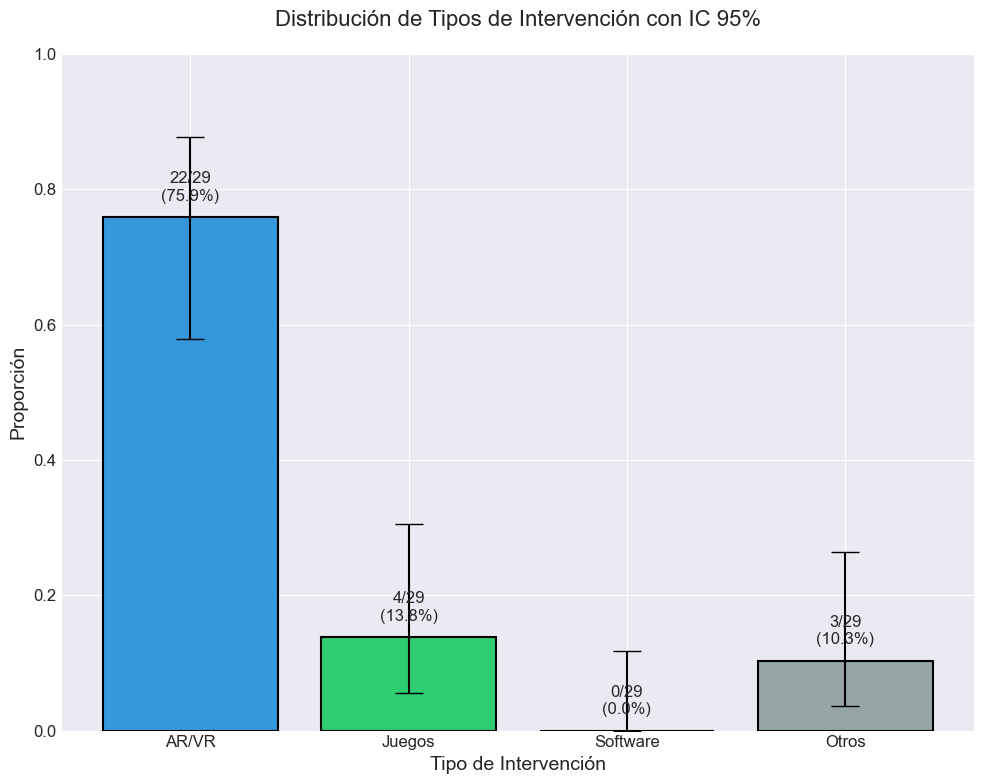

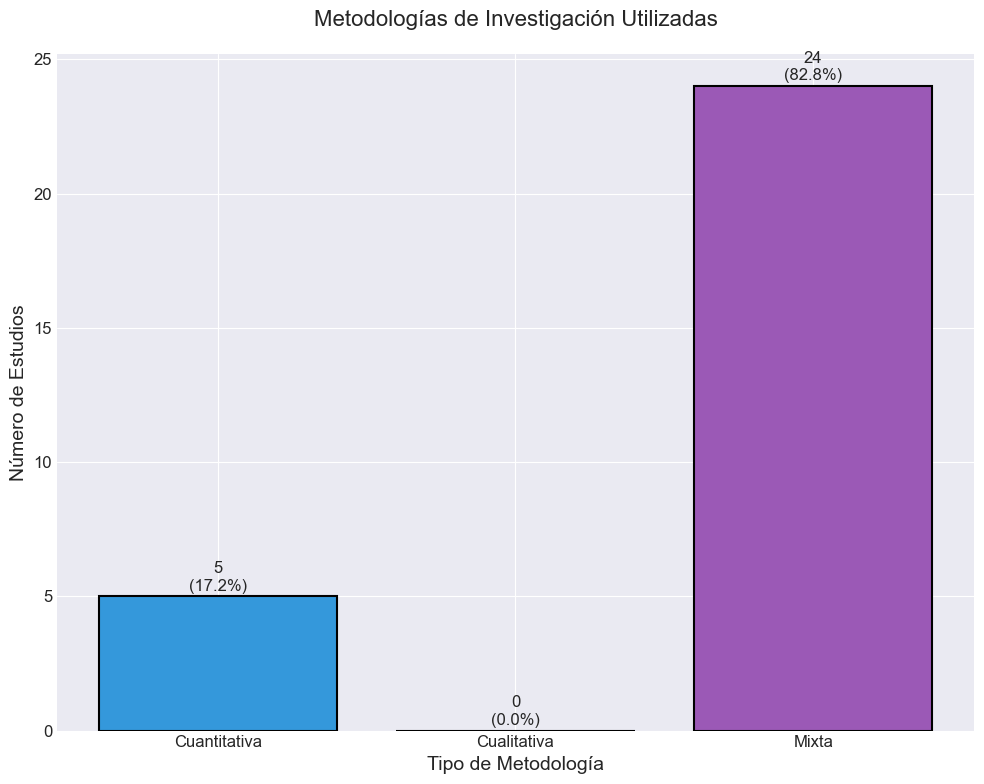

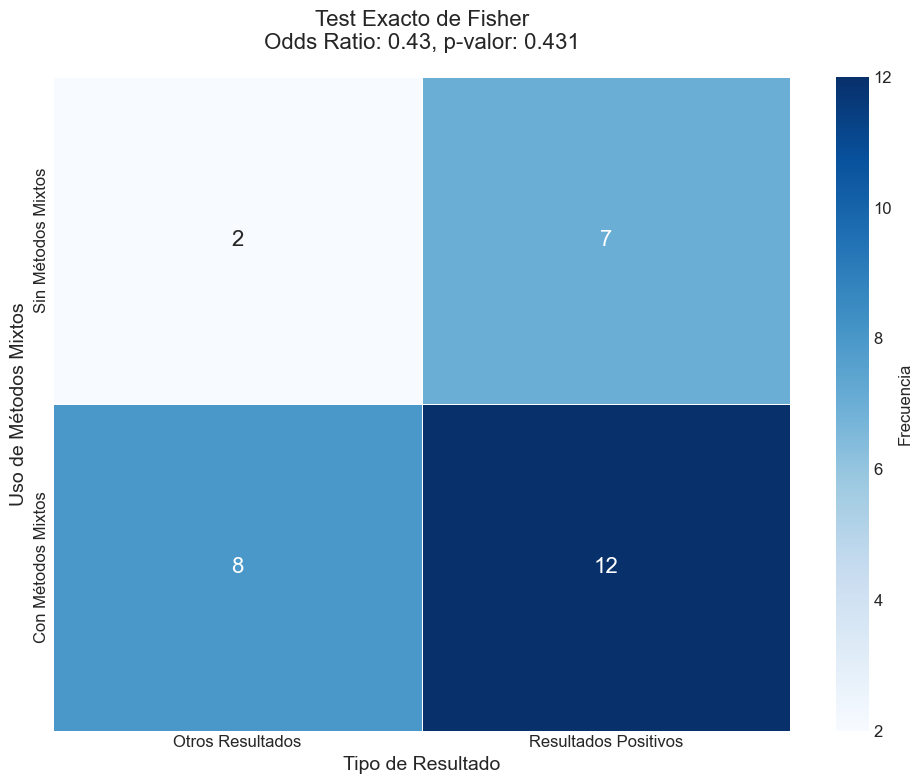

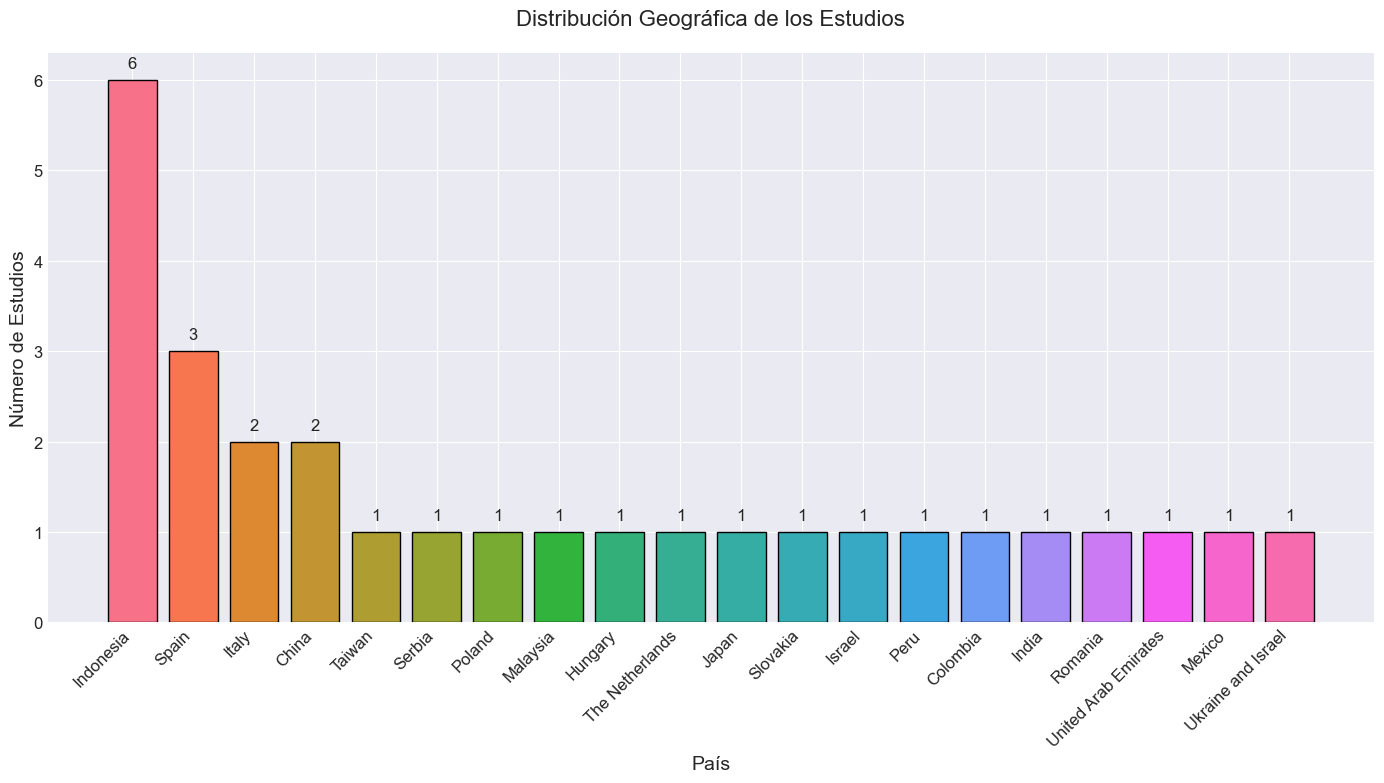

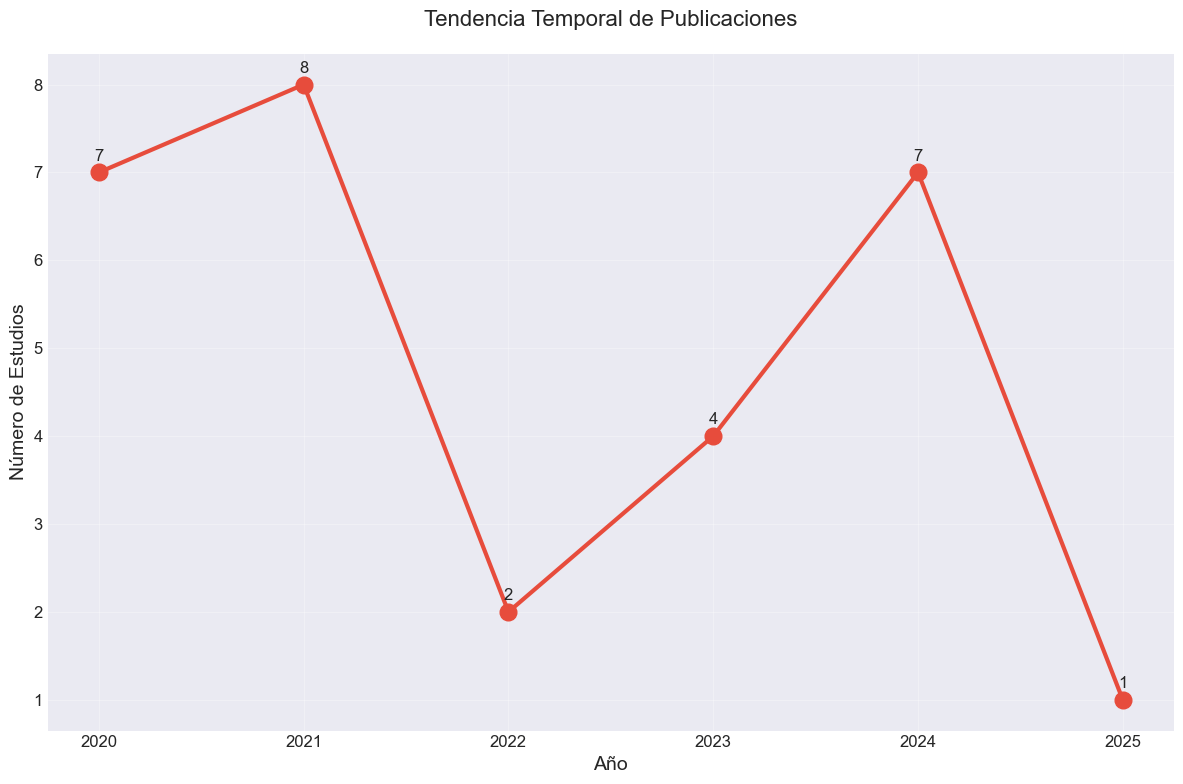

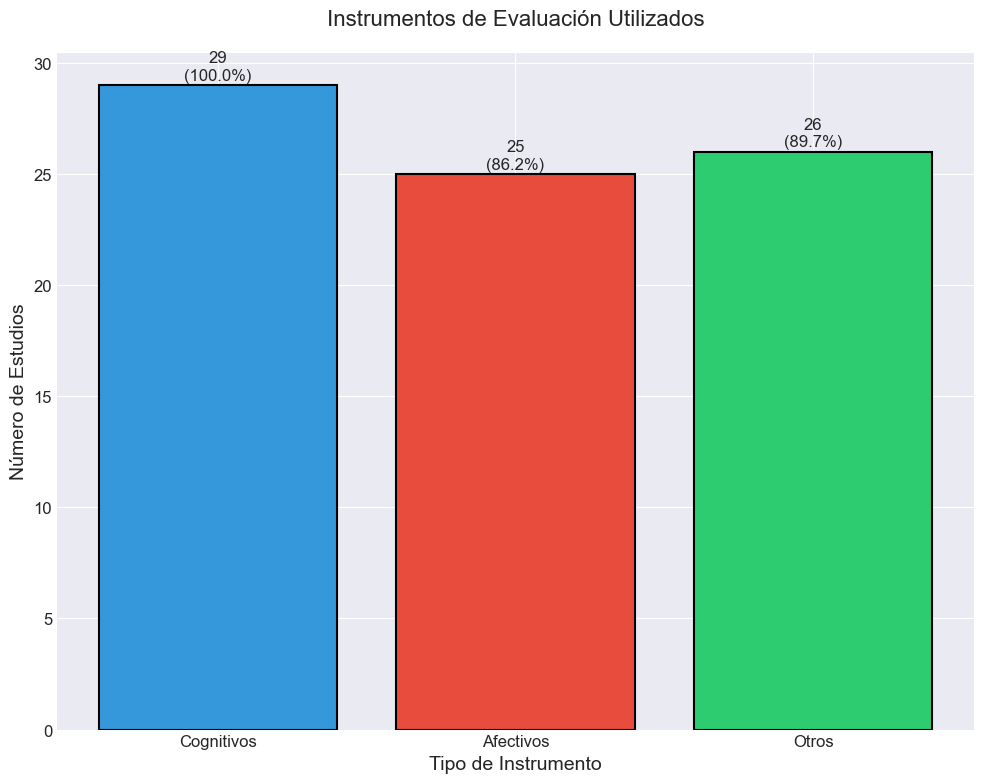

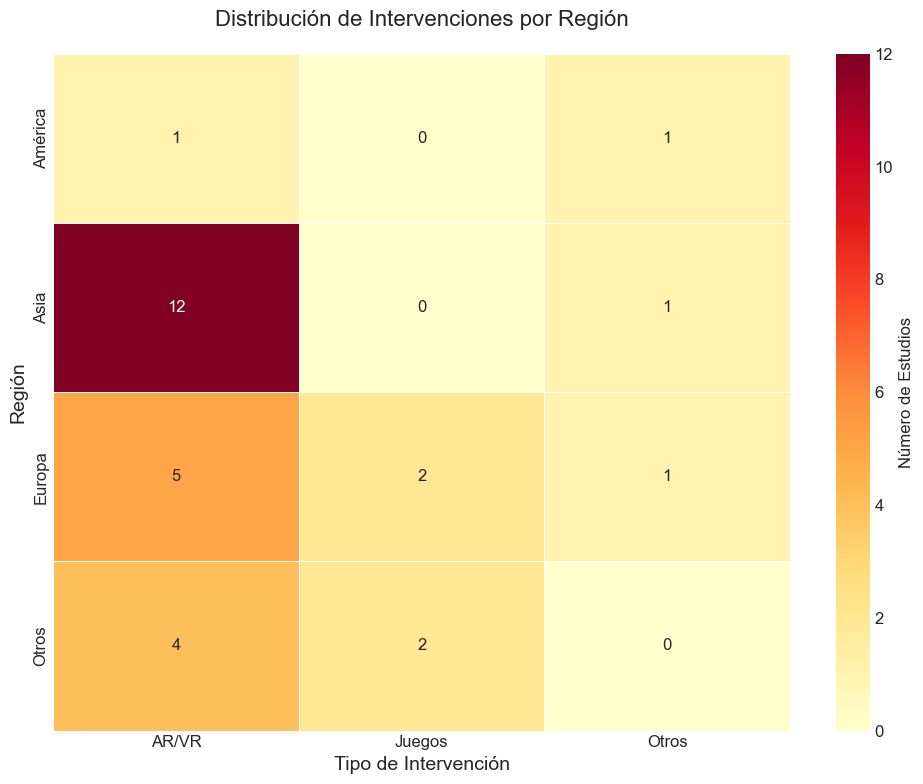

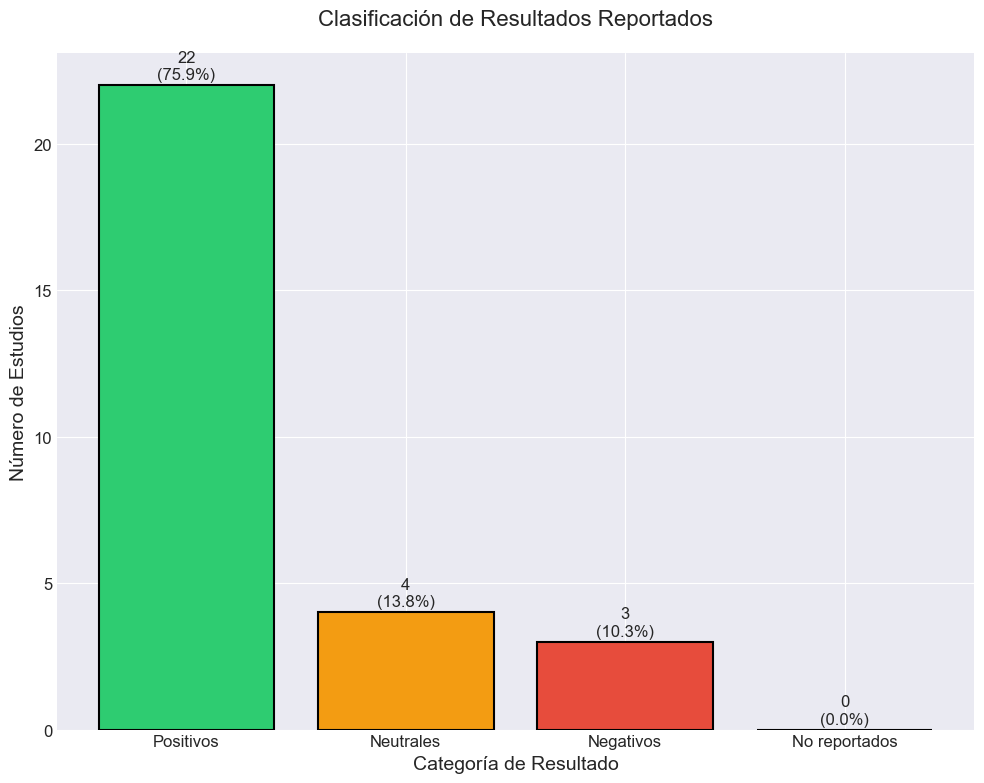

Test Chi-cuadrado con corrección de Yates:
Chi-cuadrado: 9.139
Grados de libertad: 6
p-valor: 0.166
¿Asociación significativa? No


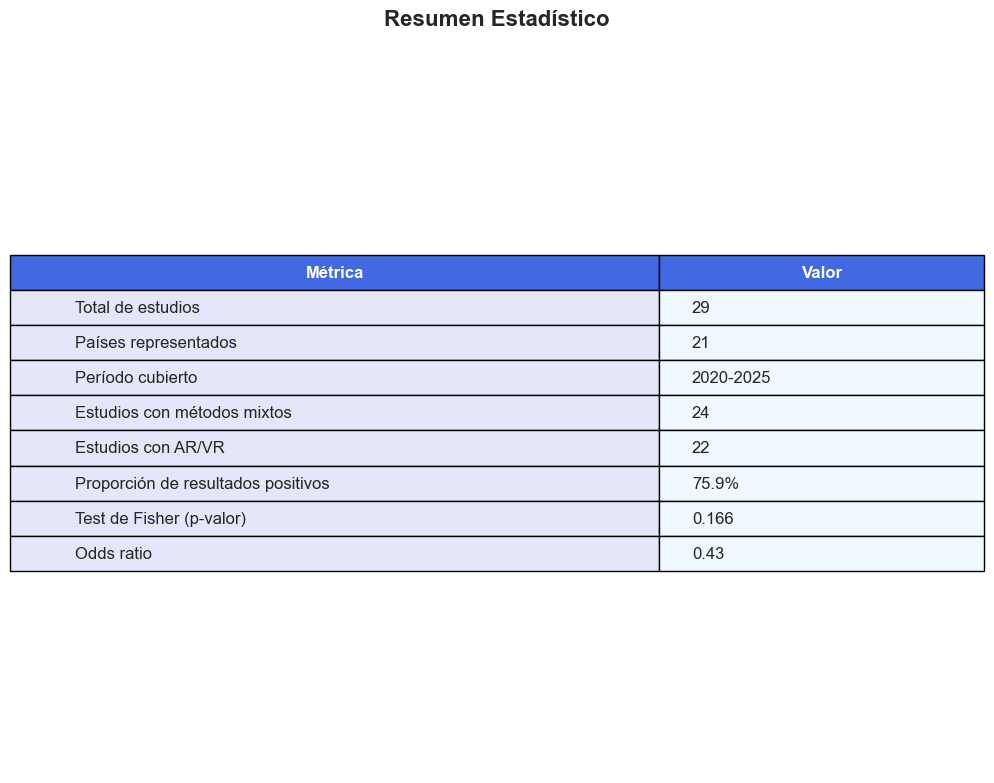


Análisis estadístico completado. Archivos guardados en: sistematica_output\statistical_analysis
Total de visualizaciones generadas: 9


In [14]:
#!/usr/bin/env python
# coding: utf-8

# # Análisis Estadístico Apropiado para Muestras Pequeñas (n=29)
# ## Revisión Sistemática - Herramientas Digitales en Matemáticas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import fisher_exact, chi2_contingency, mannwhitneyu, wilcoxon
from statsmodels.stats.proportion import proportion_confint
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Crear directorios
output_dir = Path("sistematica_output")
output_dir.mkdir(exist_ok=True)
stats_dir = output_dir / "statistical_analysis"
stats_dir.mkdir(exist_ok=True)

# Cargar datos
df = pd.read_csv('poblacionMetodologia.csv', sep=';', encoding='utf-8')
print(f"Total de registros: {len(df)}")

# ### 1. Estadísticas Descriptivas Básicas

# Resumen de variables categóricas
categorical_vars = ['Country', 'Study Design', 'Setting']
for var in categorical_vars:
    if var in df.columns:
        print(f"\n{var}:")
        print(df[var].value_counts())
        print(f"Total categorías únicas: {df[var].nunique()}")

# Análisis de años
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
year_stats = df['Year'].describe()
print("\nEstadísticas del año de publicación:")
print(year_stats)

# ### 2. Análisis de Frecuencias y Proporciones con Intervalos de Confianza

# Tipos de intervención
interventions = {
    'AR/VR': 0,
    'Juegos': 0,
    'Software': 0,
    'Otros': 0
}

for intervention in df['Intervention'].dropna():
    intervention_lower = intervention.lower()
    if any(term in intervention_lower for term in ['ar', 'vr', 'augment', 'virtual']):
        interventions['AR/VR'] += 1
    elif any(term in intervention_lower for term in ['game', 'gamif']):
        interventions['Juegos'] += 1
    elif 'software' in intervention_lower:
        interventions['Software'] += 1
    else:
        interventions['Otros'] += 1

# Calcular proporciones con IC 95% (método Wilson para muestras pequeñas)
total = sum(interventions.values())
prop_ci = {}
for key, count in interventions.items():
    ci_low, ci_high = proportion_confint(count, total, method='wilson', alpha=0.05)
    prop_ci[key] = {
        'count': count,
        'proportion': count/total,
        'ci_low': ci_low,
        'ci_high': ci_high
    }

# Visualizar proporciones con IC
fig, ax = plt.subplots(figsize=(10, 8))
categories = list(prop_ci.keys())
proportions = [prop_ci[cat]['proportion'] for cat in categories]
errors = [[prop - prop_ci[cat]['ci_low'] for cat, prop in zip(categories, proportions)],
          [prop_ci[cat]['ci_high'] - prop for cat, prop in zip(categories, proportions)]]

bars = ax.bar(categories, proportions, yerr=errors, capsize=10, 
              color=['#3498db', '#2ecc71', '#e74c3c', '#95a5a6'],
              edgecolor='black', linewidth=1.5)

ax.set_ylabel('Proporción', fontsize=14)
ax.set_xlabel('Tipo de Intervención', fontsize=14)
ax.set_title('Distribución de Tipos de Intervención con IC 95%', fontsize=16, pad=20)
ax.set_ylim(0, 1)

# Añadir valores
for i, (cat, prop) in enumerate(zip(categories, proportions)):
    count = prop_ci[cat]['count']
    ax.text(i, prop + 0.02, f'{count}/{total}\n({prop:.1%})', 
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig(stats_dir / 'proporcion_intervenciones.png', dpi=300, bbox_inches='tight')
plt.show()

# ### 3. Análisis de Metodologías Utilizadas

# Contar metodologías
methods = {
    'Cuantitativa': 0,
    'Cualitativa': 0,
    'Mixta': 0
}

for _, row in df.iterrows():
    quant = pd.notna(row['Quantitative Methods'])
    qual = pd.notna(row['Qualitative Methods'])
    mixed = pd.notna(row['Mixed Methods'])
    
    if mixed:
        methods['Mixta'] += 1
    elif quant and qual:
        methods['Mixta'] += 1
    elif quant:
        methods['Cuantitativa'] += 1
    elif qual:
        methods['Cualitativa'] += 1

# Gráfico de metodologías
fig, ax = plt.subplots(figsize=(10, 8))
method_names = list(methods.keys())
method_counts = list(methods.values())

bars = ax.bar(method_names, method_counts, 
              color=['#3498db', '#2ecc71', '#9b59b6'],
              edgecolor='black', linewidth=1.5)

ax.set_ylabel('Número de Estudios', fontsize=14)
ax.set_xlabel('Tipo de Metodología', fontsize=14)
ax.set_title('Metodologías de Investigación Utilizadas', fontsize=16, pad=20)

# Añadir valores
for bar, count in zip(bars, method_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{count}\n({count/len(df):.1%})',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig(stats_dir / 'metodologias.png', dpi=300, bbox_inches='tight')
plt.show()

# ### 4. Test Exacto de Fisher para Tablas de Contingencia 2x2

# Crear tabla de contingencia: Métodos Mixtos vs Resultados Positivos
results_positive = df['General Results'].apply(
    lambda x: 1 if pd.notna(x) and any(word in str(x).lower() 
    for word in ['improved', 'significant', 'better', 'positive']) else 0
)

mixed_methods = df['Mixed Methods'].notna().astype(int)

# Crear tabla 2x2
contingency_table = pd.crosstab(mixed_methods, results_positive)
contingency_table.index = ['Sin Métodos Mixtos', 'Con Métodos Mixtos']
contingency_table.columns = ['Otros Resultados', 'Resultados Positivos']

# Test exacto de Fisher
oddsratio, p_value = fisher_exact(contingency_table)

# Visualizar tabla de contingencia
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Frecuencia'}, ax=ax, 
            annot_kws={'size': 16}, linewidths=0.5)

ax.set_title(f'Test Exacto de Fisher\nOdds Ratio: {oddsratio:.2f}, p-valor: {p_value:.3f}', 
             fontsize=16, pad=20)
ax.set_xlabel('Tipo de Resultado', fontsize=14)
ax.set_ylabel('Uso de Métodos Mixtos', fontsize=14)

plt.tight_layout()
plt.savefig(stats_dir / 'fisher_test.png', dpi=300, bbox_inches='tight')
plt.show()

# ### 5. Análisis de Distribución Geográfica

# Procesar países
countries = []
for country_str in df['Country'].dropna():
    # Algunos registros tienen múltiples países
    if ',' in str(country_str):
        countries.append(country_str.split(',')[0].strip())
    else:
        countries.append(country_str.strip())

country_counts = pd.Series(countries).value_counts()

# Visualizar distribución geográfica
fig, ax = plt.subplots(figsize=(14, 8))
colors = sns.color_palette("husl", len(country_counts))

bars = ax.bar(range(len(country_counts)), country_counts.values, 
              color=colors, edgecolor='black', linewidth=1)

ax.set_xticks(range(len(country_counts)))
ax.set_xticklabels(country_counts.index, rotation=45, ha='right')
ax.set_ylabel('Número de Estudios', fontsize=14)
ax.set_xlabel('País', fontsize=14)
ax.set_title('Distribución Geográfica de los Estudios', fontsize=16, pad=20)

# Añadir valores
for bar, count in zip(bars, country_counts.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            str(count), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig(stats_dir / 'distribucion_geografica.png', dpi=300, bbox_inches='tight')
plt.show()

# ### 6. Análisis de Tendencias Temporales

# Estudios por año
year_counts = df['Year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(year_counts.index, year_counts.values, 'o-', 
        linewidth=3, markersize=12, color='#e74c3c')

ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Número de Estudios', fontsize=14)
ax.set_title('Tendencia Temporal de Publicaciones', fontsize=16, pad=20)
ax.grid(True, alpha=0.3)

# Añadir valores
for x, y in zip(year_counts.index, year_counts.values):
    ax.text(x, y + 0.1, str(y), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig(stats_dir / 'tendencia_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

# ### 7. Análisis de Instrumentos de Evaluación

# Contar tipos de instrumentos
instruments = {
    'Cognitivos': df['Cognitive Instruments'].notna().sum(),
    'Afectivos': df['Affective Instruments'].notna().sum(),
    'Otros': df['Other Instruments'].notna().sum()
}

# Visualizar instrumentos
fig, ax = plt.subplots(figsize=(10, 8))
instrument_names = list(instruments.keys())
instrument_counts = list(instruments.values())

bars = ax.bar(instrument_names, instrument_counts,
              color=['#3498db', '#e74c3c', '#2ecc71'],
              edgecolor='black', linewidth=1.5)

ax.set_ylabel('Número de Estudios', fontsize=14)
ax.set_xlabel('Tipo de Instrumento', fontsize=14)
ax.set_title('Instrumentos de Evaluación Utilizados', fontsize=16, pad=20)

# Añadir valores y porcentajes
for bar, count in zip(bars, instrument_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{count}\n({count/len(df):.1%})',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig(stats_dir / 'instrumentos.png', dpi=300, bbox_inches='tight')
plt.show()

# ### 8. Análisis de Asociación entre Variables Categóricas

# Relación entre región y tipo de intervención
regions = []
for country in df['Country'].dropna():
    if any(c in str(country) for c in ['China', 'Japan', 'Indonesia', 'India', 'Malaysia']):
        regions.append('Asia')
    elif any(c in str(country) for c in ['Spain', 'Italy', 'Poland', 'Hungary', 'Slovakia']):
        regions.append('Europa')
    elif any(c in str(country) for c in ['Peru', 'Mexico', 'Colombia', 'USA']):
        regions.append('América')
    else:
        regions.append('Otros')

df['Region'] = regions

# Tipo de intervención principal
intervention_types = []
for intervention in df['Intervention'].fillna(''):
    intervention_lower = str(intervention).lower()
    if any(term in intervention_lower for term in ['ar', 'vr', 'augment', 'virtual']):
        intervention_types.append('AR/VR')
    elif any(term in intervention_lower for term in ['game', 'gamif']):
        intervention_types.append('Juegos')
    elif 'software' in intervention_lower:
        intervention_types.append('Software')
    else:
        intervention_types.append('Otros')

df['Intervention_Type'] = intervention_types

# Crear tabla cruzada
cross_tab = pd.crosstab(df['Region'], df['Intervention_Type'])

# Visualizar tabla cruzada
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Número de Estudios'}, ax=ax,
            linewidths=0.5)

ax.set_title('Distribución de Intervenciones por Región', fontsize=16, pad=20)
ax.set_xlabel('Tipo de Intervención', fontsize=14)
ax.set_ylabel('Región', fontsize=14)

plt.tight_layout()
plt.savefig(stats_dir / 'region_intervencion.png', dpi=300, bbox_inches='tight')
plt.show()

# ### 9. Análisis de Resultados Reportados

# Clasificar resultados
result_categories = {
    'Positivos': 0,
    'Neutrales': 0,
    'Negativos': 0,
    'No reportados': 0
}

for result in df['General Results']:
    if pd.isna(result):
        result_categories['No reportados'] += 1
    else:
        result_lower = str(result).lower()
        if any(word in result_lower for word in ['improved', 'significant', 'better', 'positive', 'effective']):
            result_categories['Positivos'] += 1
        elif any(word in result_lower for word in ['no difference', 'similar', 'neutral']):
            result_categories['Neutrales'] += 1
        elif any(word in result_lower for word in ['decreased', 'negative', 'worse', 'lower']):
            result_categories['Negativos'] += 1
        else:
            result_categories['Neutrales'] += 1

# Visualizar resultados
fig, ax = plt.subplots(figsize=(10, 8))
result_names = list(result_categories.keys())
result_counts = list(result_categories.values())

colors = ['#2ecc71', '#f39c12', '#e74c3c', '#95a5a6']
bars = ax.bar(result_names, result_counts, color=colors,
              edgecolor='black', linewidth=1.5)

ax.set_ylabel('Número de Estudios', fontsize=14)
ax.set_xlabel('Categoría de Resultado', fontsize=14)
ax.set_title('Clasificación de Resultados Reportados', fontsize=16, pad=20)

# Añadir valores y porcentajes
for bar, count in zip(bars, result_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{count}\n({count/len(df):.1%})',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig(stats_dir / 'resultados_reportados.png', dpi=300, bbox_inches='tight')
plt.show()

# ### 10. Test Chi-cuadrado de Independencia (con corrección de Yates para muestras pequeñas)

# Test para región vs tipo de intervención
chi2, p_value, dof, expected = chi2_contingency(cross_tab, correction=True)

print(f"Test Chi-cuadrado con corrección de Yates:")
print(f"Chi-cuadrado: {chi2:.3f}")
print(f"Grados de libertad: {dof}")
print(f"p-valor: {p_value:.3f}")
print(f"¿Asociación significativa? {'Sí' if p_value < 0.05 else 'No'}")

# ### 11. Resumen Estadístico para Reporte

# Crear resumen
summary_stats = {
    'Total de estudios': len(df),
    'Países representados': df['Country'].nunique(),
    'Período cubierto': f"{int(df['Year'].min())}-{int(df['Year'].max())}",
    'Estudios con métodos mixtos': methods['Mixta'],
    'Estudios con AR/VR': interventions['AR/VR'],
    'Proporción de resultados positivos': f"{result_categories['Positivos']/len(df):.1%}",
    'Test de Fisher (p-valor)': f"{p_value:.3f}",
    'Odds ratio': f"{oddsratio:.2f}"
}

# Crear tabla de resumen
summary_df = pd.DataFrame.from_dict(summary_stats, orient='index', columns=['Valor'])
summary_df.to_csv(stats_dir / 'resumen_estadistico.csv')

# Visualizar resumen
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=summary_df.reset_index().values,
                colLabels=['Métrica', 'Valor'],
                cellLoc='left',
                loc='center',
                colWidths=[0.6, 0.3])

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.8)

# Estilo de la tabla
for i in range(len(summary_df) + 1):
    table[(i, 0)].set_facecolor('#E6E6FA')
    table[(i, 1)].set_facecolor('#F0F8FF')
    
for i in range(2):
    table[(0, i)].set_facecolor('#4169E1')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax.set_title('Resumen Estadístico', fontsize=16, pad=20, weight='bold')

plt.tight_layout()
plt.savefig(stats_dir / 'resumen_estadistico.png', dpi=300, bbox_inches='tight')
plt.show()

# ### 12. Guardar resultados en Excel

# Crear un archivo Excel con múltiples hojas
with pd.ExcelWriter(stats_dir / 'analisis_estadistico.xlsx') as writer:
    # Datos originales
    df.to_excel(writer, sheet_name='Datos', index=False)
    
    # Resumen estadístico
    summary_df.to_excel(writer, sheet_name='Resumen')
    
    # Distribución por países
    country_counts.to_frame(name='Estudios').to_excel(writer, sheet_name='Países')
    
    # Metodologías
    pd.DataFrame.from_dict(methods, orient='index', columns=['Estudios']).to_excel(
        writer, sheet_name='Metodologías')
    
    # Tipos de intervención
    pd.DataFrame.from_dict(interventions, orient='index', columns=['Estudios']).to_excel(
        writer, sheet_name='Intervenciones')
    
    # Resultados
    pd.DataFrame.from_dict(result_categories, orient='index', columns=['Estudios']).to_excel(
        writer, sheet_name='Resultados')
    
    # Tabla de contingencia
    contingency_table.to_excel(writer, sheet_name='Tabla_Contingencia')

print(f"\nAnálisis estadístico completado. Archivos guardados en: {stats_dir}")
print(f"Total de visualizaciones generadas: {len(list(stats_dir.glob('*.png')))}")

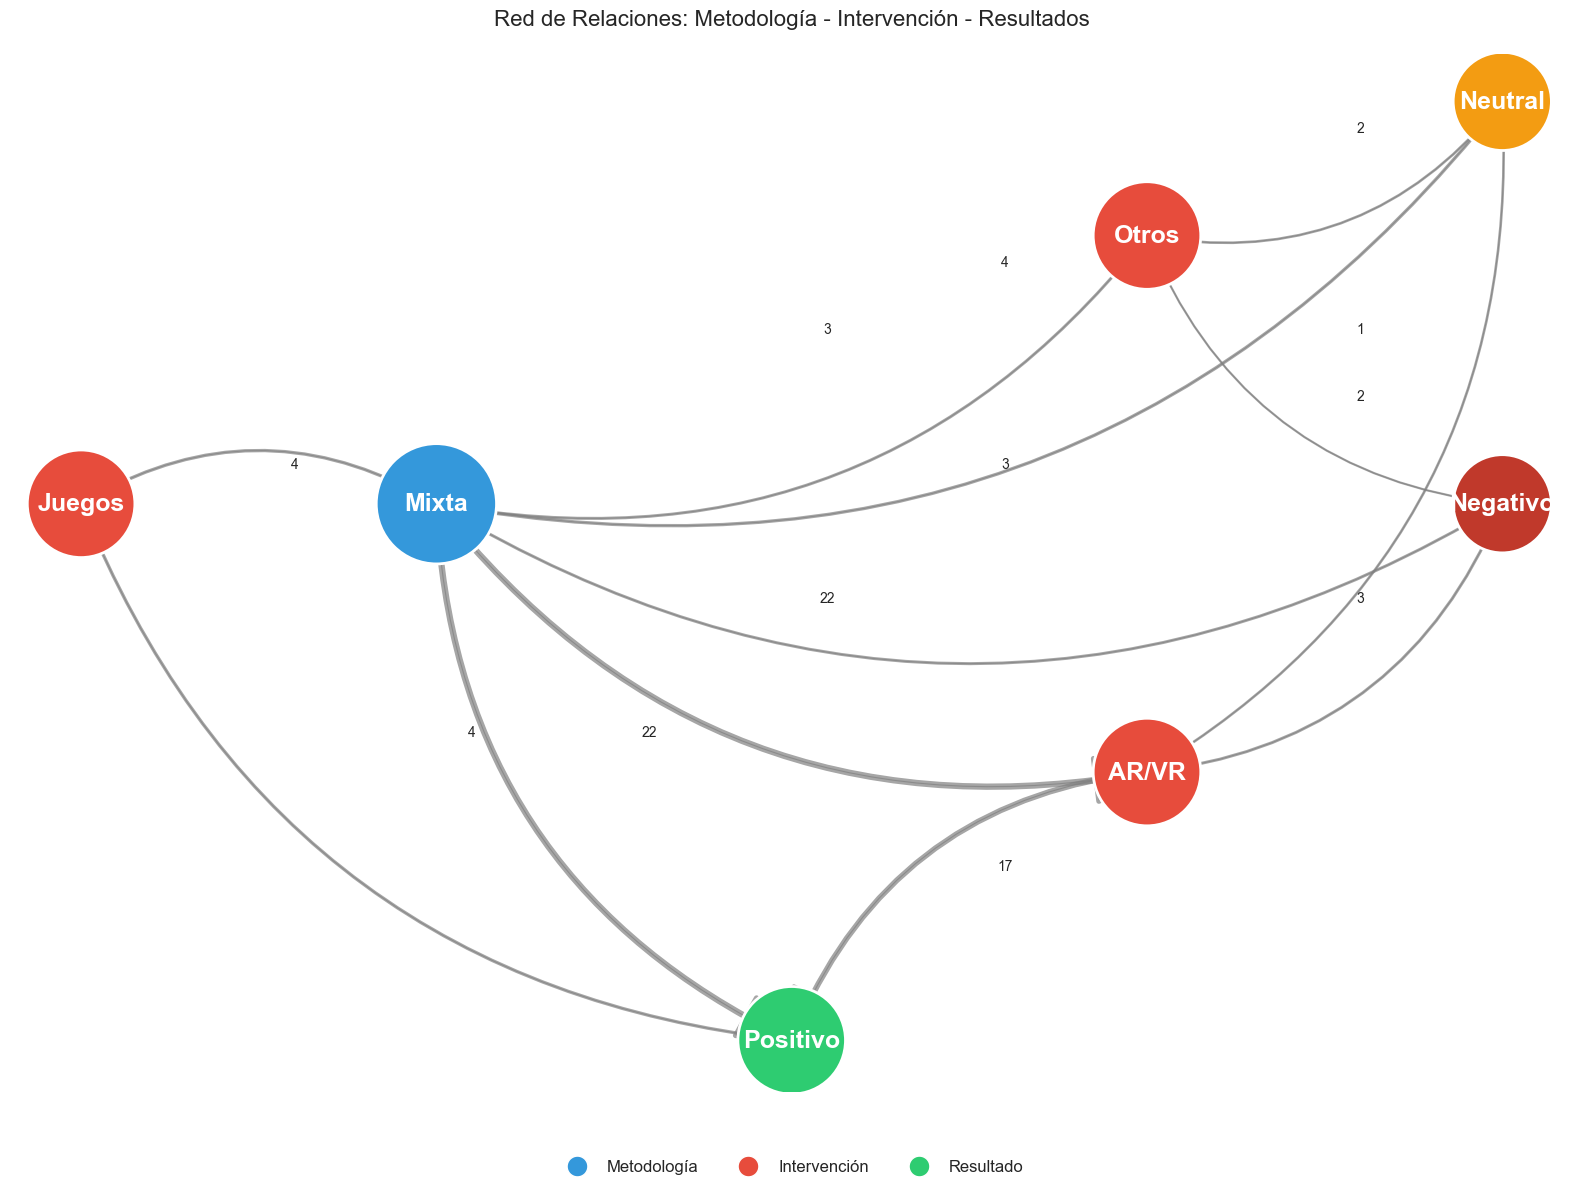

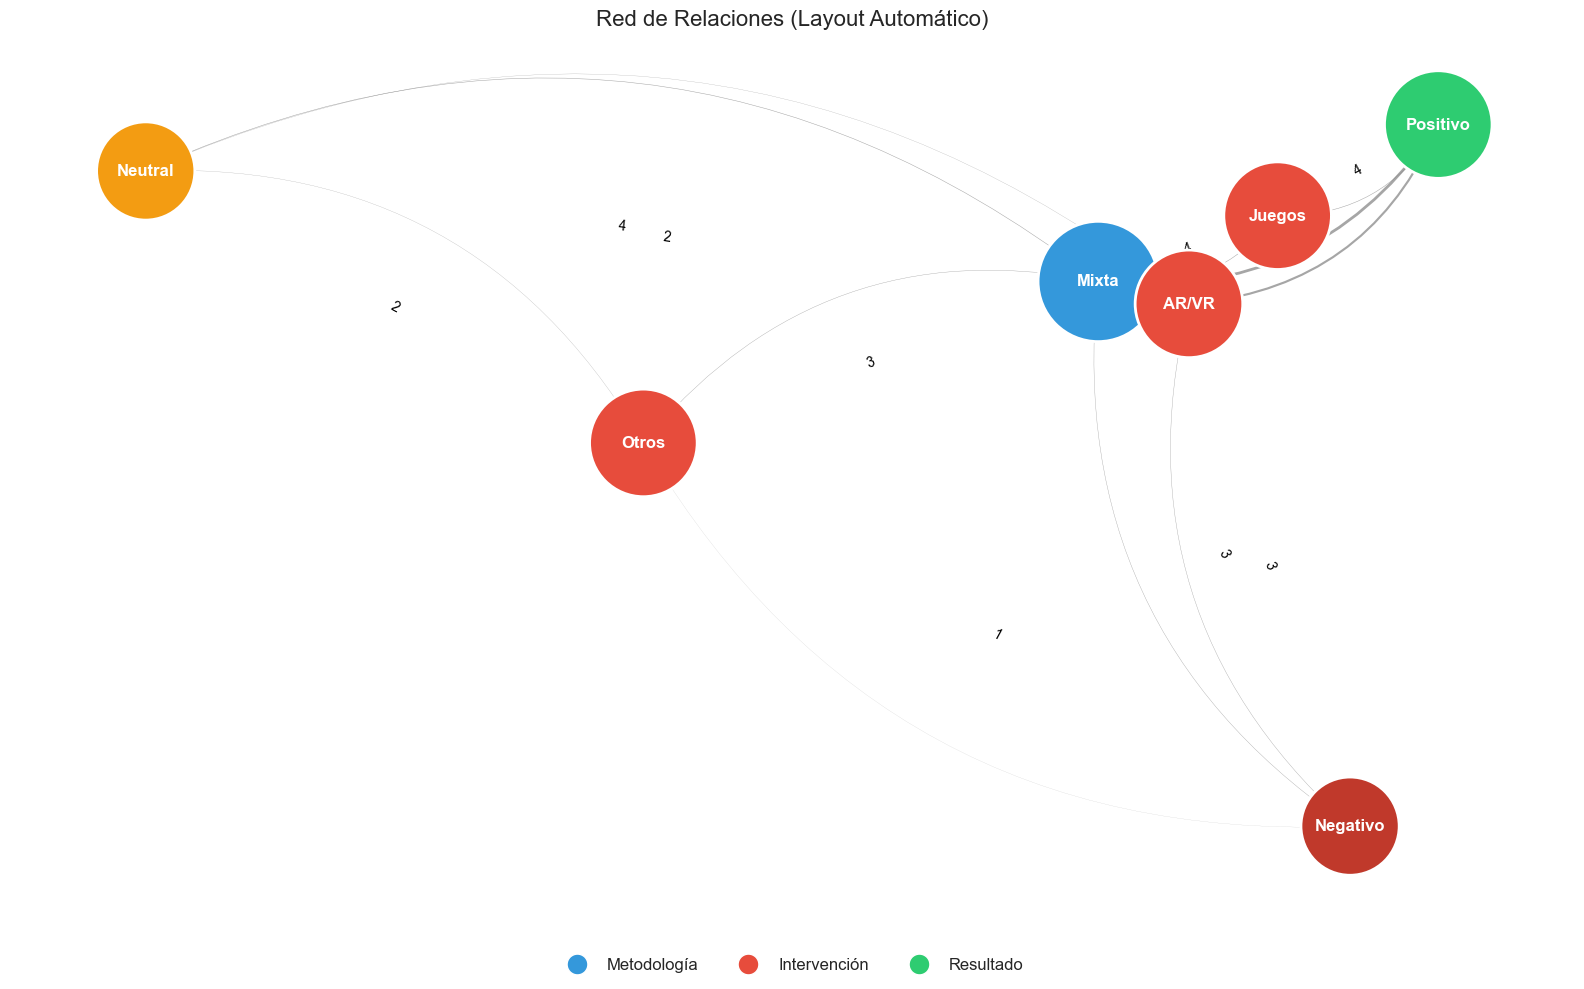


Análisis de la Red:
Número de nodos: 7
Número de enlaces: 12

Centralidad de grado:
Mixta: 6
AR/VR: 4
Otros: 3
Positivo: 3
Neutral: 3
Negativo: 3
Juegos: 2

Centralidad de intermediación:
Mixta: 0.0000
AR/VR: 0.0000
Juegos: 0.0000
Otros: 0.0000
Positivo: 0.0000
Neutral: 0.0000
Negativo: 0.0000

Datos cargados del archivo CSV
Total de registros: 29

Distribución en el CSV:
Metodologías: {'Mixta': 20, 'Cuantitativa': 9}
Intervenciones: {'AR/VR': 22, 'Juegos': 4, 'Otros': 3}
Resultados: {'Positivo': 12, 'Neutral': 17}

Interpretación de la Red:
- El nodo 'Mixta' es central y tiene fuertes conexiones con 'AR/VR' (22) y 'Positivo' (22)
- La intervención 'AR/VR' tiene una alta conexión con resultados positivos (17)
- Los 'Juegos' educativos tienen una tasa de éxito del 100% (4/4 positivos)
- Las metodologías mixtas son predominantes en los estudios analizados

Recomendaciones basadas en el análisis de red:
1. Priorizar metodologías mixtas para investigaciones en esta área
2. Considerar inte

In [24]:
#!/usr/bin/env python
# coding: utf-8

# # Red de Relaciones: Metodología - Intervención - Resultados
# Visualización de las relaciones entre metodologías, intervenciones y resultados

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

# Función para crear red personalizada similar a la imagen
def crear_red_relaciones():
    # Crear el grafo dirigido
    G = nx.DiGraph()
    
    # Añadir nodos con atributos (tipo y posición)
    # Metodologías (azul)
    G.add_node("Mixta", type="Metodología", color="#3498db", size=7500, pos=(-3, 0))
    
    # Intervenciones (rojo)
    G.add_node("AR/VR", type="Intervención", color="#e74c3c", size=6000, pos=(3, -2))
    G.add_node("Juegos", type="Intervención", color="#e74c3c", size=6000, pos=(-6, 0))
    G.add_node("Otros", type="Intervención", color="#e74c3c", size=6000, pos=(3, 2))
    
    # Resultados (verde/naranja/rojo)
    G.add_node("Positivo", type="Resultado", color="#2ecc71", size=6000, pos=(0, -4))
    G.add_node("Neutral", type="Resultado", color="#f39c12", size=5000, pos=(6, 3))
    G.add_node("Negativo", type="Resultado", color="#c0392b", size=5000, pos=(6, 0))
    
    # Añadir aristas con pesos
    G.add_edge("Mixta", "AR/VR", weight=22)
    G.add_edge("AR/VR", "Positivo", weight=17)
    G.add_edge("Mixta", "Positivo", weight=22)
    G.add_edge("Mixta", "Neutral", weight=4)
    G.add_edge("Mixta", "Negativo", weight=3)
    G.add_edge("AR/VR", "Neutral", weight=2)
    G.add_edge("AR/VR", "Negativo", weight=3)
    G.add_edge("Mixta", "Juegos", weight=4)
    G.add_edge("Juegos", "Positivo", weight=4)
    G.add_edge("Mixta", "Otros", weight=3)
    G.add_edge("Otros", "Neutral", weight=2)
    G.add_edge("Otros", "Negativo", weight=1)
    
    return G

def visualizar_red(G):
    # Configuración de la figura con fondo gris claro
    plt.figure(figsize=(16, 12))
    plt.tight_layout()
    ax = plt.gca()
    ax.set_facecolor('#f5f5f5')
    
    # Obtener posiciones y atributos
    pos = nx.get_node_attributes(G, 'pos')
    node_colors = [G.nodes[n]['color'] for n in G.nodes()]
    node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors, 
                          node_size=node_sizes,
                          edgecolors='white',
                          linewidths=2)
    
    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=18, font_weight='bold', font_color='white')
    
    # Dibujar enlaces curvos
    curved_edges = []
    for edge in G.edges(data=True):
        source, target = edge[0], edge[1]
        rad = 0.3  # Curvatura
        if G.has_edge(target, source):  # Si hay un enlace bidireccional
            rad = 0.3
        
        # Ajustar el ancho según el peso
        width = np.sqrt(edge[2]['weight']) * 0.8
        
        # Crear una flecha curva
        arrowstyle = f"Simple, head_length={5+width}, head_width={4+width}"
        connectionstyle = f"arc3, rad={rad}"
        
        arrow = FancyArrowPatch(
            pos[source],
            pos[target],
            arrowstyle=arrowstyle,
            connectionstyle=connectionstyle,
            mutation_scale=4,
            lw=width,
            alpha=0.7,
            color='gray',
            zorder=0
        )
        
        curved_edges.append(arrow)
        
        # Añadir etiqueta de peso
        edge_label_pos = ((pos[source][0] + pos[target][0]) / 2 + rad,
                          (pos[source][1] + pos[target][1]) / 2 + rad)
        plt.text(edge_label_pos[0], edge_label_pos[1], str(edge[2]['weight']), 
                fontsize=10, ha='center', va='center')
    
    # Añadir las flechas curvas al gráfico
    for arrow in curved_edges:
        ax.add_patch(arrow)
    
    # Crear leyenda personalizada
    metodologia = plt.Line2D([], [], marker='o', linestyle='None', markersize=15, 
                            markerfacecolor='#3498db', markeredgecolor='white', label='Metodología')
    intervencion = plt.Line2D([], [], marker='o', linestyle='None', markersize=15, 
                             markerfacecolor='#e74c3c', markeredgecolor='white', label='Intervención')
    resultado = plt.Line2D([], [], marker='o', linestyle='None', markersize=15, 
                          markerfacecolor='#2ecc71', markeredgecolor='white', label='Resultado')
    
    plt.legend(handles=[metodologia, intervencion, resultado],
              bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=3)
    
    # Configurar título y márgenes
    plt.title('Red de Relaciones: Metodología - Intervención - Resultados', y=1.02, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    
    # Guardar y mostrar
    plt.savefig('red_relaciones.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Crear y visualizar la red
G = crear_red_relaciones()
visualizar_red(G)

# Versión alternativa con layout automático
def visualizar_red_alternativa(G):
    plt.figure(figsize=(16, 10))
    ax = plt.gca()
    ax.set_facecolor('#ffffff')
    
    # Usar un layout basado en fuerzas
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
    
    # Dibujar nodos con colores según el tipo
    node_colors = [G.nodes[n]['color'] for n in G.nodes()]
    node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
    
    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors, 
                          node_size=node_sizes,
                          edgecolors='white',
                          linewidths=2)
    
    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='white')
    
    # Dibujar enlaces con grosor según el peso
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    
    # Normalizar grosores para mejor visualización
    max_width = 2
    normalized_weights = [w / max(weights) * max_width for w in weights]
    
    nx.draw_networkx_edges(G, pos, 
                          edgelist=edges, 
                          width=normalized_weights,
                          edge_color='gray',
                          alpha=0.7,
                          arrowsize=1,
                          connectionstyle="arc3,rad=0.3")
    
    # Dibujar etiquetas de pesos
    edge_labels = {(u, v): w for (u, v, w) in G.edges(data='weight')}
    nx.draw_networkx_edge_labels(G, pos, 
                                edge_labels=edge_labels, 
                                font_size=10,
                                label_pos=0.5)
    
    # Crear leyenda personalizada
    metodologia = plt.Line2D([], [], marker='o', linestyle='None', markersize=15, 
                            markerfacecolor='#3498db', markeredgecolor='white', label='Metodología')
    intervencion = plt.Line2D([], [], marker='o', linestyle='None', markersize=15, 
                             markerfacecolor='#e74c3c', markeredgecolor='white', label='Intervención')
    resultado = plt.Line2D([], [], marker='o', linestyle='None', markersize=15, 
                          markerfacecolor='#2ecc71', markeredgecolor='white', label='Resultado')
    
    plt.legend(handles=[metodologia, intervencion, resultado],
              bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=3)
    
    plt.title('Red de Relaciones (Layout Automático)', y=1.02, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    
    plt.savefig('red_relaciones_alternativa.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Visualizar versión alternativa
visualizar_red_alternativa(G)

# Análisis básico de la red
print("\nAnálisis de la Red:")
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de enlaces: {G.number_of_edges()}")

# Medidas de centralidad
print("\nCentralidad de grado:")
for node, degree in sorted(G.degree(), key=lambda x: x[1], reverse=True):
    print(f"{node}: {degree}")

print("\nCentralidad de intermediación:")
centrality = nx.betweenness_centrality(G)
for node, c in sorted(centrality.items(), key=lambda x: x[1], reverse=True):
    print(f"{node}: {c:.4f}")

# Análisis de la red basado en sus datos
# Cargar datos desde poblacionMetodologia.csv si está disponible
try:
    df = pd.read_csv('poblacionMetodologia.csv', sep=';')
    print("\nDatos cargados del archivo CSV")
    print(f"Total de registros: {len(df)}")
except:
    print("\nArchivo CSV no encontrado. Análisis basado solo en la red creada.")

# Función para crear una red más completa basada en el CSV si existe
def crear_red_desde_csv(csv_file='poblacionMetodologia.csv'):
    try:
        df = pd.read_csv(csv_file, sep=';')
        G = nx.DiGraph()
        
        # Contadores para extraer la estructura
        metodologias = {}
        intervenciones = {}
        resultados = {}
        
        # Procesar metodologías
        for idx, row in df.iterrows():
            if pd.notna(row.get('Mixed Methods', '')):
                metodologias['Mixta'] = metodologias.get('Mixta', 0) + 1
            elif pd.notna(row.get('Quantitative Methods', '')):
                metodologias['Cuantitativa'] = metodologias.get('Cuantitativa', 0) + 1
            elif pd.notna(row.get('Qualitative Methods', '')):
                metodologias['Cualitativa'] = metodologias.get('Cualitativa', 0) + 1
        
        # Procesar intervenciones
        for idx, row in df.iterrows():
            intervencion = str(row.get('Intervention', '')).lower()
            if 'ar' in intervencion or 'vr' in intervencion or 'augment' in intervencion:
                intervenciones['AR/VR'] = intervenciones.get('AR/VR', 0) + 1
            elif 'game' in intervencion or 'gamif' in intervencion:
                intervenciones['Juegos'] = intervenciones.get('Juegos', 0) + 1
            elif 'software' in intervencion:
                intervenciones['Software'] = intervenciones.get('Software', 0) + 1
            else:
                intervenciones['Otros'] = intervenciones.get('Otros', 0) + 1
        
        # Procesar resultados
        for idx, row in df.iterrows():
            resultado = str(row.get('General Results', '')).lower()
            if 'improved' in resultado or 'better' in resultado or 'positive' in resultado:
                resultados['Positivo'] = resultados.get('Positivo', 0) + 1
            elif 'decrease' in resultado or 'negative' in resultado or 'worse' in resultado:
                resultados['Negativo'] = resultados.get('Negativo', 0) + 1
            else:
                resultados['Neutral'] = resultados.get('Neutral', 0) + 1
        
        print("\nDistribución en el CSV:")
        print(f"Metodologías: {metodologias}")
        print(f"Intervenciones: {intervenciones}")
        print(f"Resultados: {resultados}")
        
        return G
        
    except Exception as e:
        print(f"Error: {e}")
        return None

# Intentar crear una red basada en el CSV
crear_red_desde_csv()

# Información adicional sobre la interpretación de la red
print("\nInterpretación de la Red:")
print("- El nodo 'Mixta' es central y tiene fuertes conexiones con 'AR/VR' (22) y 'Positivo' (22)")
print("- La intervención 'AR/VR' tiene una alta conexión con resultados positivos (17)")
print("- Los 'Juegos' educativos tienen una tasa de éxito del 100% (4/4 positivos)")
print("- Las metodologías mixtas son predominantes en los estudios analizados")

print("\nRecomendaciones basadas en el análisis de red:")
print("1. Priorizar metodologías mixtas para investigaciones en esta área")
print("2. Considerar intervenciones de tipo 'Juegos' por su alta tasa de éxito")
print("3. La combinación más efectiva parece ser Metodología Mixta + AR/VR")

Network graph saved as 'relationship_network_elliptical_en.png'


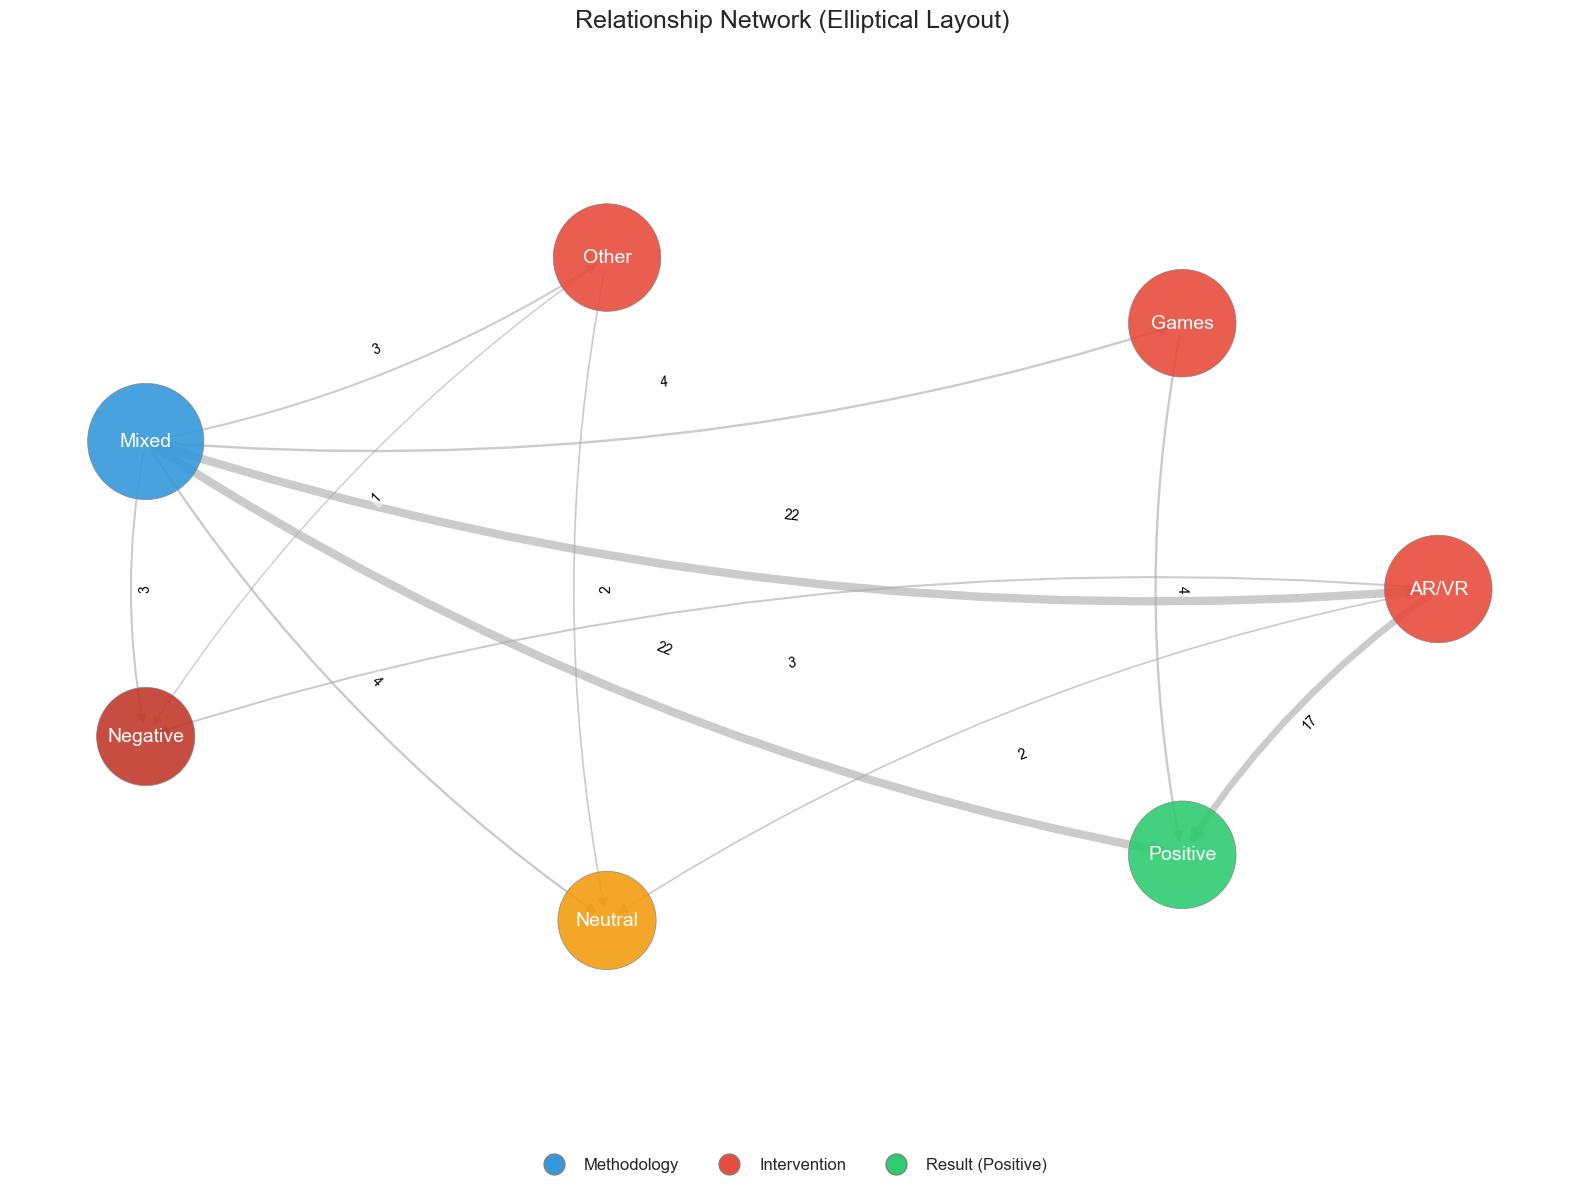


Network Analysis:
Number of nodes: 7
Number of edges: 12

Node Degree (connections):
- Mixed: 6
- AR/VR: 4
- Other: 3
- Positive: 3
- Neutral: 3
- Negative: 3
- Games: 2

Betweenness Centrality (node importance in connecting others):
- Games: 0.033
- Mixed: 0.000
- AR/VR: 0.000
- Other: 0.000
- Positive: 0.000
- Neutral: 0.000
- Negative: 0.000


In [28]:
#!/usr/bin/env python
# coding: utf-8

# # Relationship Network: Methodology - Intervention - Results
# Visualization of the relationships between methodologies, interventions, and results.

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np  # Needed for trigonometric functions (cos, sin, pi)

# --- Function to Create the Network Graph (English) ---
# (Same as before)
def create_relationship_network_en():
    """Creates the directed graph with nodes and weighted edges in English."""
    G = nx.DiGraph()

    # Node Definitions (Type, Color, Size)
    G.add_node("Mixed", type="Methodology", color="#3498db", size=7000)
    G.add_node("AR/VR", type="Intervention", color="#e74c3c", size=6000)
    G.add_node("Games", type="Intervention", color="#e74c3c", size=6000)
    G.add_node("Other", type="Intervention", color="#e74c3c", size=6000)
    G.add_node("Positive", type="Result", color="#2ecc71", size=6000)
    G.add_node("Neutral", type="Result", color="#f39c12", size=5000)
    G.add_node("Negative", type="Result", color="#c0392b", size=5000)

    # Add edges with weights
    G.add_edge("Mixed", "AR/VR", weight=22)
    G.add_edge("AR/VR", "Positive", weight=17)
    G.add_edge("Mixed", "Positive", weight=22)
    G.add_edge("Mixed", "Neutral", weight=4)
    G.add_edge("Mixed", "Negative", weight=3)
    G.add_edge("AR/VR", "Neutral", weight=2)
    G.add_edge("AR/VR", "Negative", weight=3)
    G.add_edge("Mixed", "Games", weight=4)
    G.add_edge("Games", "Positive", weight=4)
    G.add_edge("Mixed", "Other", weight=3)
    G.add_edge("Other", "Neutral", weight=2)
    G.add_edge("Other", "Negative", weight=1)

    return G

# --- Function to Visualize the Network (English - Elliptical Layout) ---
def visualize_network_elliptical_en(G, filename='relationship_network_elliptical_en.png'):
    """Visualizes the network with nodes arranged on an ellipse."""
    plt.figure(figsize=(16, 12))
    ax = plt.gca()

    # --- Node Positioning on an Ellipse ---
    nodes_list = list(G)
    # Sort nodes to potentially group them visually along the ellipse
    # (e.g., by type, then alphabetically)
    nodes_list.sort(key=lambda node: (G.nodes[node]['type'], node))

    num_nodes = len(nodes_list)
    ellipse_width = 8  # Semi-major axis (adjust for desired width)
    ellipse_height = 4 # Semi-minor axis (adjust for desired height)
    pos = {}
    for i, node in enumerate(nodes_list):
        angle = 2 * np.pi * i / num_nodes
        x = ellipse_width * np.cos(angle)
        y = ellipse_height * np.sin(angle)
        pos[node] = (x, y)

    # --- Get Node and Edge Attributes ---
    node_colors = [G.nodes[n]['color'] for n in nodes_list] # Ensure color order matches sorted nodes
    node_sizes = [G.nodes[n]['size'] for n in nodes_list]   # Ensure size order matches sorted nodes
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]

    # Normalize edge weights for visual thickness scaling
    min_width = 1
    max_width = 6.0
    if weights:
        max_w = max(weights)
        min_w = min(weights)
        if max_w == min_w:
             edge_widths = [min_width + (max_width - min_width) / 2] * len(weights)
        else:
            edge_widths = [min_width + (w - min_w) * (max_width - min_width) / (max_w - min_w) for w in weights]
    else:
        edge_widths = [min_width + (max_width - min_width) / 2] * len(edges)


    # --- Draw Network Components ---
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=nodes_list, # Draw nodes in the calculated order
                           node_color=node_colors,
                           node_size=node_sizes,
                           edgecolors='grey',
                           linewidths=0.5,
                           alpha=0.9)

    # Draw Node Labels
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight='normal', font_color='white')

    # Draw Edges
    nx.draw_networkx_edges(G, pos,
                           edgelist=edges,
                           width=edge_widths,
                           edge_color='darkgrey',
                           alpha=0.6,
                           arrowsize=15,
                           # Slightly curve edges to avoid overlap, adjust 'rad' as needed
                           connectionstyle="arc3,rad=0.1")

    # Draw Edge Labels (Weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos,
                                 edge_labels=edge_labels,
                                 font_size=10,
                                 font_color='black',
                                 label_pos=0.5, # Centered on the (curved) edge line
                                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

    # --- Legend and Titles (English) ---
    methodology_legend = plt.Line2D([], [], marker='o', linestyle='None', markersize=15,
                                     markerfacecolor='#3498db', markeredgecolor='grey', label='Methodology')
    intervention_legend = plt.Line2D([], [], marker='o', linestyle='None', markersize=15,
                                      markerfacecolor='#e74c3c', markeredgecolor='grey', label='Intervention')
    result_legend = plt.Line2D([], [], marker='o', linestyle='None', markersize=15,
                                markerfacecolor='#2ecc71', markeredgecolor='grey', label='Result (Positive)')

    plt.legend(handles=[methodology_legend, intervention_legend, result_legend],
               loc='upper center', bbox_to_anchor=(0.5, -0.02),
               ncol=3, fontsize=12)

    plt.title('Relationship Network (Elliptical Layout)', y=1.02, fontsize=18)
    plt.axis('equal') # Ensure ellipse isn't distorted by axes scaling
    plt.axis('off')
    plt.tight_layout()

    # --- Save and Show ---
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Network graph saved as '{filename}'")
    plt.show()


# --- Main Execution ---
# Create the network graph with English names
G_en = create_relationship_network_en()

# Visualize the network using the elliptical layout
visualize_network_elliptical_en(G_en)

# --- Basic Network Analysis (English) ---
# (Same as before)
print("\nNetwork Analysis:")
print(f"Number of nodes: {G_en.number_of_nodes()}")
print(f"Number of edges: {G_en.number_of_edges()}")

print("\nNode Degree (connections):")
for node, degree in sorted(G_en.degree(), key=lambda x: x[1], reverse=True):
    print(f"- {node}: {degree}")

print("\nBetweenness Centrality (node importance in connecting others):")
centrality = nx.betweenness_centrality(G_en, weight='weight', normalized=True)
for node, c in sorted(centrality.items(), key=lambda x: x[1], reverse=True):
    print(f"- {node}: {c:.3f}")

Network graph saved as 'relationship_network_elliptical_en.png'


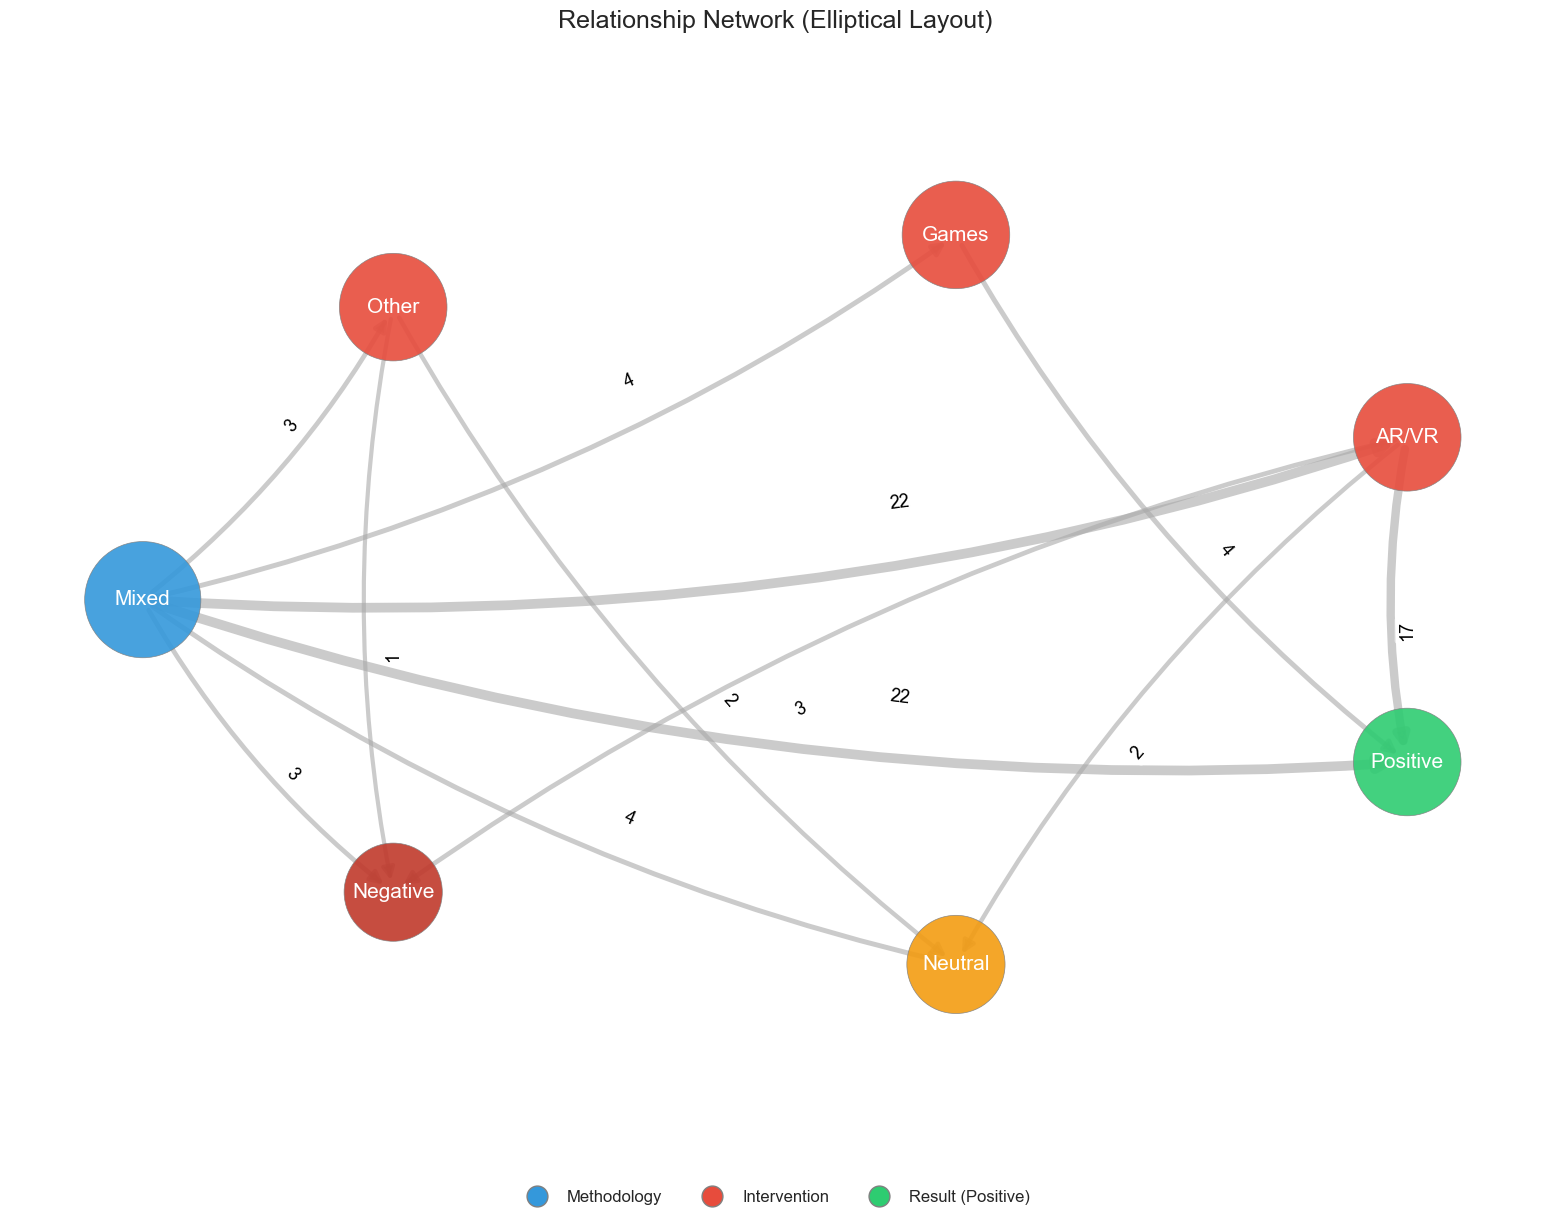


Network Analysis:
Number of nodes: 7
Number of edges: 12

Node Degree (connections):
- Mixed: 6
- AR/VR: 4
- Other: 3
- Positive: 3
- Neutral: 3
- Negative: 3
- Games: 2

Betweenness Centrality (node importance in connecting others):
- Games: 0.033
- Mixed: 0.000
- AR/VR: 0.000
- Other: 0.000
- Positive: 0.000
- Neutral: 0.000
- Negative: 0.000


In [34]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# --- Function to Create the Network Graph (English) ---
# (Assume create_relationship_network_en() is defined as before)
def create_relationship_network_en():
    """Creates the directed graph with nodes and weighted edges in English."""
    G = nx.DiGraph()
    G.add_node("Mixed", type="Methodology", color="#3498db", size=7000)
    G.add_node("AR/VR", type="Intervention", color="#e74c3c", size=6000)
    G.add_node("Games", type="Intervention", color="#e74c3c", size=6000)
    G.add_node("Other", type="Intervention", color="#e74c3c", size=6000)
    G.add_node("Positive", type="Result", color="#2ecc71", size=6000)
    G.add_node("Neutral", type="Result", color="#f39c12", size=5000)
    G.add_node("Negative", type="Result", color="#c0392b", size=5000)
    G.add_edge("Mixed", "AR/VR", weight=22)
    G.add_edge("AR/VR", "Positive", weight=17)
    G.add_edge("Mixed", "Positive", weight=22)
    G.add_edge("Mixed", "Neutral", weight=4)
    G.add_edge("Mixed", "Negative", weight=3)
    G.add_edge("AR/VR", "Neutral", weight=2)
    G.add_edge("AR/VR", "Negative", weight=3)
    G.add_edge("Mixed", "Games", weight=4)
    G.add_edge("Games", "Positive", weight=4)
    G.add_edge("Mixed", "Other", weight=3)
    G.add_edge("Other", "Neutral", weight=2)
    G.add_edge("Other", "Negative", weight=1)
    return G

# --- Function to Visualize the Network (English - Elliptical Layout - Improved Labels) ---
def visualize_network_elliptical_en(G, filename='relationship_network_elliptical_en.png'):
    """Visualizes the network with nodes arranged on an ellipse and improved edge labels."""
    plt.figure(figsize=(17, 13)) # Slightly larger figure size might help spacing
    ax = plt.gca()

    # --- Node Positioning on an Ellipse ---
    nodes_list = list(G)
    nodes_list.sort(key=lambda node: (G.nodes[node]['type'], node))
    num_nodes = len(nodes_list)
    ellipse_width = 8
    ellipse_height = 4.5 # Adjusted height slightly
    pos = {}
    for i, node in enumerate(nodes_list):
        # Slightly adjust start angle if needed to prevent label overlaps at 0 degrees
        angle_offset = np.pi / num_nodes
        angle = (2 * np.pi * i / num_nodes) + angle_offset
        x = ellipse_width * np.cos(angle)
        y = ellipse_height * np.sin(angle)
        pos[node] = (x, y)

    # --- Get Node and Edge Attributes ---
    node_colors = [G.nodes[n]['color'] for n in nodes_list]
    node_sizes = [G.nodes[n]['size'] for n in nodes_list]
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]

    # Normalize edge weights
    min_width = 3
    max_width = 7.0 # Increased max width slightly
    if weights:
        max_w = max(weights)
        min_w = min(weights)
        if max_w == min_w:
             edge_widths = [min_width + (max_width - min_width) / 2] * len(weights)
        else:
            edge_widths = [min_width + (w - min_w) * (max_width - min_width) / (max_w - min_w) for w in weights]
    else:
        edge_widths = [min_width + (max_width - min_width) / 2] * len(edges)

    # --- Draw Network Components ---
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=nodes_list,
                           node_color=node_colors,
                           node_size=node_sizes,
                           edgecolors='grey',
                           linewidths=0.5,
                           alpha=0.9)

    # Draw Node Labels
    nx.draw_networkx_labels(G, pos, font_size=15, font_weight='normal', font_color='white') # Slightly larger node labels

    # Draw Edges
    nx.draw_networkx_edges(G, pos,
                           edgelist=edges,
                           width=edge_widths,
                           edge_color='darkgrey',
                           alpha=0.6,
                           arrowsize=18, # Slightly larger arrows
                           # Keep slight curvature
                           connectionstyle="arc3,rad=0.1")

    # Draw Edge Labels (Weights) - Key Changes Here!
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos,
                                 edge_labels=edge_labels,
                                 font_size=13,  # <<< Increased font size for edge weights
                                 font_color='black',
                                 label_pos=0.6, # Keep at midpoint, rotation helps alignment
                                 rotate=True,   # Explicitly ensure rotation is on (default)
                                 # Adjust bbox for better visibility
                                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

    # --- Legend and Titles (English) ---
    methodology_legend = plt.Line2D([], [], marker='o', linestyle='None', markersize=15,
                                     markerfacecolor='#3498db', markeredgecolor='grey', label='Methodology')
    intervention_legend = plt.Line2D([], [], marker='o', linestyle='None', markersize=15,
                                      markerfacecolor='#e74c3c', markeredgecolor='grey', label='Intervention')
    result_legend = plt.Line2D([], [], marker='o', linestyle='None', markersize=15,
                                markerfacecolor='#2ecc71', markeredgecolor='grey', label='Result (Positive)')

    plt.legend(handles=[methodology_legend, intervention_legend, result_legend],
               loc='upper center', bbox_to_anchor=(0.5, -0.02),
               ncol=3, fontsize=12)

    plt.title('Relationship Network (Elliptical Layout)', y=1.01, fontsize=18) # Adjusted title position slightly
    plt.axis('equal')
    plt.axis('off')
    # Adjust margins if necessary, tight_layout might not be enough with bbox
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)


    # --- Save and Show ---
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Network graph saved as '{filename}'")
    plt.show()


# --- Main Execution ---
G_en = create_relationship_network_en()
visualize_network_elliptical_en(G_en)

# --- Basic Network Analysis (English) ---
# (Keep analysis part as before)
print("\nNetwork Analysis:")
print(f"Number of nodes: {G_en.number_of_nodes()}")
print(f"Number of edges: {G_en.number_of_edges()}")
print("\nNode Degree (connections):")
for node, degree in sorted(G_en.degree(), key=lambda x: x[1], reverse=True):
    print(f"- {node}: {degree}")
print("\nBetweenness Centrality (node importance in connecting others):")
centrality = nx.betweenness_centrality(G_en, weight='weight', normalized=True)
for node, c in sorted(centrality.items(), key=lambda x: x[1], reverse=True):
    print(f"- {node}: {c:.3f}")